In [7]:
import sys
sys.path.append("..")
from src.DataBaseManager import DBMS, QUERY_CATALOG
from config import LAND_COVER_PALETTE, LAND_COVER_LEGEND
import contextily as ctx
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pandas as pd
from tqdm import tqdm
from PIL import Image

from src.plotting.sankey import plot_sankey

import geemap

import ee
from src.utils import authenticate_Google_Earth_Engine as authenticate

from IPython.display import Image as IPy_Image




In [8]:
authenticate()

Initializing Earth Engine with Aske's project


In [13]:
years = [str(year) for year in range(2016,2024)]



def brighten(band):
    alpha=0.13
    beta=0
    return np.clip(alpha*band+beta, 0,255)

def sql_list_strings(list_):
    return ','.join(["'"+str(i)+"'" for i in list_])

def get_LULC_for_chips(chipids,year,country):
    DB = DBMS()
    results = DB.read('GET_DW_LANDCOVER',{'_CHIPIDS_':sql_list_strings(chipids),
                                '_AREA_':country,
                                '_START_YEAR_':year,
                                '_END_YEAR_':year},
                                geom_query = True)   


    return results 


import numpy as np
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

def brighten(band, lower_percent=2, upper_percent=98):
    """
    Brighten the image by applying contrast stretching.
    """
    # Compute the lower and upper percentile
    lower = np.percentile(band, lower_percent)
    upper = np.percentile(band, upper_percent)
    
    # Clip the band to the lower and upper percentiles and scale it to 0-1
    band = np.clip((band - lower) / (upper - lower), 0, 1)
    
    return band

def enhance_image(vals):
    """
    Enhance the image by brightening and adjusting gamma.
    """
    bands = []
    for band in vals[:3]:
        band = brighten(band)
        bands.append(band)
    
    # Stack the bands back together
    enhanced_image = np.stack(bands, axis=0)
    
    # Apply gamma correction
    gamma = 1.2  # You can adjust this value to your preference
    enhanced_image = np.power(enhanced_image, gamma)
    
    return enhanced_image






# This is the cloud masking function provided by GEE but adapted for use in Python.
def maskS2clouds(image):
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0)
    mask = mask.bitwiseAnd(cirrusBitMask).eq(0)

    return image.updateMask(mask).divide(10000)

def get_S2_image(results,year,data_dir):

    
    
    ROI = results.dissolve()
    fc = geemap.geopandas_to_ee(ROI[["geometries"]])
    #return fc
    # Define the geometry of the area for which you would like images.
    try:
        geom = ee.Geometry.Polygon(fc.geometry().getInfo()['coordinates'])
    except:
        geom = ee.Geometry.MultiPolygon(fc.geometry().getInfo()['coordinates'])
    # Call collection of satellite images.
    collection = (ee.ImageCollection("COPERNICUS/S2")
                # Select the Red, Green and Blue image bands, as well as the cloud masking layer.
                .select(['B4', 'B3', 'B2', 'QA60'])
                # Filter for images within a given date range.
                .filter(ee.Filter.date(f'{year}-01-01', f'{year}-12-31'))
                # Filter for images that overlap with the assigned geometry.
                .filterBounds(geom)
                # Filter for images that have less then 20% cloud coverage.
                .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
                # Apply cloud mask.
                .map(maskS2clouds)
                )

    # Sort images in the collection by index (which is equivalent to sorting by date), 
    # with the oldest images at the front of the collection.
    # Convert collection into a single image mosaic where only images at the top of the collection are visible.
    image = collection.sort('system:index', opt_ascending=False).mosaic()


    scale = 50  # Scale in meters.
    region = geom.buffer(1000).bounds().getInfo()['coordinates']



    url = image.getDownloadURL({
        'scale': scale,
        'region': region,
        'format': 'GEO_TIFF',
        'bands': ['B4', 'B3', 'B2']
    })

    num = int(random.random()*1000)
    image_path = data_dir+f'sentinel2_image_{num}.tif'
    geemap.download_file(url, image_path)


    return image_path



def plot_sentinel_image(image_path, chipid,year,data_dir):

    # Open the downloaded image.
    with rasterio.open(image_path) as src:
        # Read the RGB bands
        vals = src.read([1, 2, 3])

        fig, ax = plt.subplots(figsize=(10, 10))
        plt.tight_layout()
        
        # Enhance the image
        enhanced_vals = enhance_image(vals)
        
        # Display the enhanced image
        chipid_str = data_dir.split('/')[-2]
        show(enhanced_vals, ax=ax, title=f"Sentinel-2 Image of {chipid_str} in {year}")

        # remove axis
        ax.axis('off')
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        # save image to png
        plt.savefig(data_dir + f'{year}_S2.png',bbox_inches='tight')
        plt.close(fig)

        return ax

    
def plot_LULC_map(gdf,chipid,year,data_dir='../plots/chips/'):

    colormap = {LAND_COVER_LEGEND[ix]: LAND_COVER_PALETTE[ix] for ix in LAND_COVER_PALETTE.keys()}
    # Ensure the 'name' column exists and maps to the correct land cover class
    gdf = gdf.sort_values(['data_origins','name'])
    gdf['color'] = gdf['name'].map(colormap)  # Default to black if not found
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.tight_layout()
    
    # Plot the entire GeoDataFrame at once using the 'color' column for color coding
    ax2  = gdf.plot(ax=ax, color=gdf['color'], alpha=0.75)  # Adjust alpha as needed

    # Add the OSM Mapnik map as the base layer
    ctx.add_basemap(ax2, source=ctx.providers.OpenStreetMap.Mapnik, crs=gdf.crs.to_string())

    ax2.set_xlim(gdf.total_bounds[[0, 2]])
    ax2.set_ylim(gdf.total_bounds[[1, 3]])
    
    chipid_str = data_dir.split('/')[-3]
    
    plt.title(f"Land Use and Land Cover Map of {chipid_str} in {year}", fontweight='bold')

    # remove axis
    ax2.axis('off')

    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)

    plt.tight_layout()
    # save image to png
    plt.savefig(data_dir + f'{year}_LULC.png',bbox_inches='tight')
    plt.close(fig)





def plot_year(chipid,year,country = "Denmark",intermediate_dir='./',gee_dir='./'):
    
    print("Getting LULC data")
    results = get_LULC_for_chips(chipids=chipid,year=year,country=country)

    print("Getting satellite image")
    image_path = get_S2_image(results,year,data_dir=gee_dir)

    ax = plot_LULC_map(results,chipid=chipid,year=year,data_dir=intermediate_dir)
    ax = plot_sentinel_image(image_path,chipid,year,data_dir=intermediate_dir)

def cm_to_inch(cm):
    return cm * 0.393701

def create_intermediate_plots(chipids,years,country = "Denmark",intermediate_dir='./',gee_dir='./'):
    for year in tqdm(years):
        year = str(year)
        plot_year(chipid=chipids,year=year,country=country,intermediate_dir=intermediate_dir,gee_dir=gee_dir)


def create_massive_subplot(chipid,years,data_dir='../plots/chips/',intermediate_dir='./'):
    plt.style.use('fivethirtyeight')
    vert = 29/8*len(years)

    aspect_ratio = 9/vert
    fixed_width_cm = 13
    fixed_width_inch = cm_to_inch(fixed_width_cm)

    height_inch = fixed_width_inch / aspect_ratio


    fig, ax = plt.subplots(len(years),2, figsize=(fixed_width_inch, height_inch))

    for year in years:
        
        img = plt.imread(f'{intermediate_dir}{year}_S2.png')
        ax[int(year)-2016,0].imshow(img)
        ax[int(year)-2016,0].axis('off')


        img = plt.imread(f'{intermediate_dir}{year}_LULC.png')
        ax[int(year)-2016,1].imshow(img)
        ax[int(year)-2016,1].axis('off')

    chipid_str = data_dir.split('/')[-2]
    plt.suptitle(f"Land Use and Land Cover Maps of {chipid_str} from {min(years)} to {max(years)}", fontweight='bold', fontsize=10)

    
    plt.tight_layout()
    plt.savefig(f'{data_dir}massive_subplot.png',bbox_inches='tight')
    plt.close(fig)


def create_intermediate_yearly_subplots(chipid,years,data_dir='../plots/chips/',intermediate_dir='./'):
    plt.style.use('fivethirtyeight')
    for year in years:

        fig, ax = plt.subplots(1,2, figsize=(16, 6.25))
        plt.tight_layout()
        
        img = plt.imread(f'{intermediate_dir}{year}_S2.png')
        ax[0].imshow(img)
        ax[0].axis('off')


        img = plt.imread(f'{intermediate_dir}{year}_LULC.png')
        ax[1].imshow(img)
        ax[1].axis('off')

        chipid_str = data_dir.split('/')[-2]
        plt.suptitle(f"Land Use and Land Cover Map of {chipid_str} for {year}", fontweight='bold', fontsize=16)

        plt.tight_layout()
                
        plt.savefig(f'{intermediate_dir}{year}_combined.png',bbox_inches='tight')
        plt.close(fig)


def create_directories(chipid,data_dir='../plots/chips/',selected=False):

    if selected:

        data_dir = data_dir + f'selected/{selected}/'
        # if the directory does not exist, create it
        if not os.path.exists(data_dir):
            os.mkdir(data_dir)

    chipid_str = '|'.join(sorted(chipid))
    if not os.path.exists(data_dir + f'{chipid_str}'):
        data_dir = data_dir + f'{chipid_str}/'
        os.mkdir(data_dir)

        gee_dir = data_dir+"support_files/"
        os.mkdir(gee_dir)
        
        intermediate_dir = data_dir + 'intermediate_plots/'
        os.mkdir(intermediate_dir)
    else:
        data_dir = data_dir + f'{chipid_str}/'
        gee_dir = data_dir+"support_files/"
        intermediate_dir = data_dir + 'intermediate_plots/'

    return data_dir,gee_dir,intermediate_dir,chipid_str

def create_gif_from_images(data_dir,years, duration=1000):

    images = ["intermediate_plots/"+f"{year}_combined.png" for year in years]
    images.sort()  # Ensure images are in order

    # Read the images
    frames = [Image.open(os.path.join(data_dir, image)) for image in images]

    # Save as a GIF
    if frames:
        frames[0].save(
            data_dir+"LULC.gif",
            format='GIF',
            append_images=frames[1:],
            save_all=True,
            duration=duration,
            loop=0
        )
    else:
        print("No PNG images found in the specified folder.")

def plot_chip_sankey(chipid,year_from,year_to,data_dir,country = "Denmark"):
    DB = DBMS()

    results = DB.read('GET_SINGLE_CHIP_GRAPH',{'_CHIPID_':chipid,
                                '_YEAR_FROM_':year_from,
                                '_YEAR_TO_':year_to,
                                '_AREA_':country})   


    plot_sankey(results,title=f"{chipid}",outpath=f"{data_dir}{chipid}_sankey.png")



def plot_chip(chipid,years,country = "Denmark",selected = False):

    if not isinstance(chipid,list):
        chipid = [chipid]


    data_dir,gee_dir,intermediate_dir,chipid_str = create_directories(chipid,selected=selected)


    create_intermediate_plots(chipid,years,country=country,intermediate_dir=intermediate_dir,gee_dir=gee_dir)

    create_massive_subplot(chipid,years,data_dir,intermediate_dir)

    create_intermediate_yearly_subplots(chipid,years,data_dir,intermediate_dir)

    create_gif_from_images(data_dir, years)

    plot_chip_sankey(chipid[0],years[0],years[-1],data_dir,country=country)
    

  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/4aef05c8d63525e7cddbe9cbfb58f474-3cfe54d12badb2845987e5638b648b7a:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/DESERTIFICATION/1_3_19/support_files/sentinel2_image_975.tif
100%|██████████| 453k/453k [00:00<00:00, 595kB/s]
 12%|█▎        | 1/8 [00:36<04:15, 36.48s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/a2613721ef6c9f7b3f51cb899df1fdf1-fa52539e9ea2001364d9a442665f5c1f:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/DESERTIFICATION/1_3_19/support_files/sentinel2_image_759.tif
100%|██████████| 451k/451k [00:00<00:00, 757kB/s]
 25%|██▌       | 2/8 [01:36<05:03, 50.56s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/dbab5d08bc6c1d48ed0a6b58239fe6cd-af8797bf5b55bf68765fe27e1093ec72:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/DESERTIFICATION/1_3_19/support_files/sentinel2_image_650.tif
100%|██████████| 452k/452k [00:00<00:00, 593kB/s]
 38%|███▊      | 3/8 [02:22<04:01, 48.22s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/530acae19e21c5c6f7a1622750967636-4c8976acf9e68eaaaa18af7e20c05fcd:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/DESERTIFICATION/1_3_19/support_files/sentinel2_image_662.tif
100%|██████████| 463k/463k [00:00<00:00, 584kB/s]
 50%|█████     | 4/8 [02:55<02:48, 42.12s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/8c507d1fa2bd0e5b81e4174f11e481a2-93c742c7299d6c2f5bc4c33c339ff7cd:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/DESERTIFICATION/1_3_19/support_files/sentinel2_image_741.tif
100%|██████████| 449k/449k [00:00<00:00, 814kB/s]
 62%|██████▎   | 5/8 [03:33<02:01, 40.66s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/08efa0f9fae90ad8ffd8c3a9c4c0d271-52661969d5f337e9816a5573dc2b44cf:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/DESERTIFICATION/1_3_19/support_files/sentinel2_image_180.tif
100%|██████████| 446k/446k [00:00<00:00, 812kB/s]
 75%|███████▌  | 6/8 [04:06<01:16, 38.21s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/9d7a276bceea99cdf055c77c08661c45-c4754174ebcc1658c5dc3224c0a6917d:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/DESERTIFICATION/1_3_19/support_files/sentinel2_image_228.tif
100%|██████████| 453k/453k [00:00<00:00, 557kB/s]
 88%|████████▊ | 7/8 [04:39<00:36, 36.48s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/68446cbf73920ac687ef05c0bdfc1a39-f8996453017096492452c72512d77fe5:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/DESERTIFICATION/1_3_19/support_files/sentinel2_image_176.tif
100%|██████████| 450k/450k [00:00<00:00, 768kB/s]
100%|██████████| 8/8 [05:08<00:00, 38.60s/it]


Saving plot to ../plots/chips/selected/DESERTIFICATION/1_3_19/1_3_19_sankey.png


  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/129036ea22b14f7dd328be9af91a0a31-02e1b73e9051cc82ca561be050795bdf:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/DEFORESTATION/14_3_12/support_files/sentinel2_image_845.tif
100%|██████████| 609k/609k [00:00<00:00, 668kB/s]
 12%|█▎        | 1/8 [00:47<05:30, 47.27s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/41d962dc1dd7b6390db0c022c98d910d-523ca9a5c3486cee08edc67b1f088e10:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/DEFORESTATION/14_3_12/support_files/sentinel2_image_755.tif
100%|██████████| 574k/574k [00:00<00:00, 972kB/s]
 25%|██▌       | 2/8 [01:52<05:46, 57.76s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/3c93a4588d6d72d1cddd8a4012e27394-3387384f167eefd7b566735c97adbb23:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/DEFORESTATION/14_3_12/support_files/sentinel2_image_345.tif
100%|██████████| 516k/516k [00:00<00:00, 762kB/s]
 38%|███▊      | 3/8 [02:40<04:26, 53.26s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/3935ed70cb94757839c03d62c48cb0a7-154dcaf633452a274da7b7e76e964b03:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/DEFORESTATION/14_3_12/support_files/sentinel2_image_699.tif
100%|██████████| 510k/510k [00:00<00:00, 674kB/s]
 50%|█████     | 4/8 [03:28<03:25, 51.40s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/5a0a295271fefd0933c9f9abffbddf45-f4819c2ac22c65190a9675a31997ee49:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/DEFORESTATION/14_3_12/support_files/sentinel2_image_757.tif
100%|██████████| 620k/620k [00:00<00:00, 921kB/s]
 62%|██████▎   | 5/8 [04:15<02:29, 49.79s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/00d19916055e44029ddba8be93cd8e09-116b37af99701394e38cd909624e5295:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/DEFORESTATION/14_3_12/support_files/sentinel2_image_712.tif
100%|██████████| 534k/534k [00:00<00:00, 851kB/s]
 75%|███████▌  | 6/8 [05:08<01:41, 50.65s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/a2d36a04739e0ade87b9e4314bf97ef6-d00cb362b6b2f1e7b04d795845b769e0:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/DEFORESTATION/14_3_12/support_files/sentinel2_image_626.tif
100%|██████████| 511k/511k [00:00<00:00, 739kB/s]
 88%|████████▊ | 7/8 [05:56<00:49, 49.89s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/f459880b7a08e6354ce4fa84f6db1420-39e8dd2423c3778d43bf02e55bb58245:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/DEFORESTATION/14_3_12/support_files/sentinel2_image_859.tif
100%|██████████| 506k/506k [00:00<00:00, 738kB/s]
100%|██████████| 8/8 [06:40<00:00, 50.07s/it]


Saving plot to ../plots/chips/selected/DEFORESTATION/14_3_12/14_3_12_sankey.png


  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/3f48cba698cddf43d87d2a3a03187df0-a3bd9b551629607480e257bcdb95c34e:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/SOLAR_EXPANSION/1_3_16/support_files/sentinel2_image_513.tif
100%|██████████| 454k/454k [00:00<00:00, 694kB/s]
 12%|█▎        | 1/8 [00:30<03:36, 30.87s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/5d1ef0fd4151166b62a4e34c0e3e278d-551de17226d3660d55ad283b0fc9af98:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/SOLAR_EXPANSION/1_3_16/support_files/sentinel2_image_332.tif
100%|██████████| 454k/454k [00:00<00:00, 850kB/s]
 25%|██▌       | 2/8 [00:59<02:55, 29.29s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/e079ccbf656e0899e10f87ad786ff14f-1a3307bd4b221b8367455aa3c7e40636:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/SOLAR_EXPANSION/1_3_16/support_files/sentinel2_image_51.tif
100%|██████████| 457k/457k [00:00<00:00, 781kB/s]
 38%|███▊      | 3/8 [01:32<02:35, 31.16s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/da6f1fedfcd6b8f884125546d79c7e0d-b2163b8547f4011741ed24dac8c11447:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/SOLAR_EXPANSION/1_3_16/support_files/sentinel2_image_178.tif
100%|██████████| 457k/457k [00:00<00:00, 762kB/s]
 50%|█████     | 4/8 [02:01<02:00, 30.15s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/db61bdf3c0ce1d8100e8264fe23f868b-1eb6db0b4de66f3b90a4eeddb9c44026:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/SOLAR_EXPANSION/1_3_16/support_files/sentinel2_image_385.tif
100%|██████████| 453k/453k [00:00<00:00, 590kB/s]
 62%|██████▎   | 5/8 [02:29<01:28, 29.45s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/456800bbc372896bb60b73a675787267-2a94114ab25e08e265a5324bd0b2ae74:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/SOLAR_EXPANSION/1_3_16/support_files/sentinel2_image_622.tif
100%|██████████| 449k/449k [00:00<00:00, 782kB/s]
 75%|███████▌  | 6/8 [02:59<00:59, 29.84s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/2e0a9d844f12ff6b42c5ed82ad2a933e-06edf7cb7044598caa1d047641736532:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/SOLAR_EXPANSION/1_3_16/support_files/sentinel2_image_971.tif
100%|██████████| 457k/457k [00:00<00:00, 703kB/s]
 88%|████████▊ | 7/8 [03:29<00:29, 29.72s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/89c154addc48376b701cfd76ec46b435-2634ba3628bb225aa0bb9bcdd54c1af6:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/SOLAR_EXPANSION/1_3_16/support_files/sentinel2_image_602.tif
100%|██████████| 464k/464k [00:00<00:00, 818kB/s]
100%|██████████| 8/8 [04:01<00:00, 30.15s/it]


Saving plot to ../plots/chips/selected/SOLAR_EXPANSION/1_3_16/1_3_16_sankey.png


  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/575c67ac723b04374b562cb99641d548-99d6416f9bff18bc70dc980d5ee5a3e5:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/URBAN_SPRAWL/1_8_37/support_files/sentinel2_image_669.tif
100%|██████████| 440k/440k [00:00<00:00, 562kB/s]
 12%|█▎        | 1/8 [00:33<03:51, 33.06s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/cc03dd30d613e4e6ca6d40043133f549-25c2f46a71a77ff15c3eeccf82c169a6:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/URBAN_SPRAWL/1_8_37/support_files/sentinel2_image_311.tif
100%|██████████| 437k/437k [00:00<00:00, 775kB/s]
 25%|██▌       | 2/8 [01:13<03:44, 37.36s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/614387c43735ef56aba607be9bb18c3e-be260c530375a671ff106d462cb6638d:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/URBAN_SPRAWL/1_8_37/support_files/sentinel2_image_658.tif
100%|██████████| 470k/470k [00:00<00:00, 819kB/s]
 38%|███▊      | 3/8 [01:49<03:03, 36.65s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/c475cc55da4c7d68839dedb21545f01c-60b0363c3a682435fe5c699d899e9cd1:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/URBAN_SPRAWL/1_8_37/support_files/sentinel2_image_752.tif
100%|██████████| 436k/436k [00:00<00:00, 746kB/s]
 50%|█████     | 4/8 [02:25<02:26, 36.65s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/b9a2173d2f060a0b012590682b81b2bb-7e100404e942e3af8c73a7175fe627e3:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/URBAN_SPRAWL/1_8_37/support_files/sentinel2_image_315.tif
100%|██████████| 438k/438k [00:00<00:00, 663kB/s]
 62%|██████▎   | 5/8 [03:01<01:49, 36.40s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/f0df0a5fc3212046c74a9f5f59d1f4c9-15d804e73dabff7ddf55715e97d6816f:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/URBAN_SPRAWL/1_8_37/support_files/sentinel2_image_574.tif
100%|██████████| 443k/443k [00:00<00:00, 786kB/s]
 75%|███████▌  | 6/8 [03:39<01:13, 36.74s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/7f202856d690f1624fc5220f2b3d33a3-9279f1b7fb63a721add36822bdbc1d50:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/URBAN_SPRAWL/1_8_37/support_files/sentinel2_image_171.tif
100%|██████████| 480k/480k [00:00<00:00, 652kB/s]
 88%|████████▊ | 7/8 [04:23<00:39, 39.36s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/f637b192b65d49fb8b8ed68174255aff-f9e1f38336be8555436d05510421bf6b:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/URBAN_SPRAWL/1_8_37/support_files/sentinel2_image_885.tif
100%|██████████| 456k/456k [00:00<00:00, 763kB/s]
100%|██████████| 8/8 [05:00<00:00, 37.59s/it]


Saving plot to ../plots/chips/selected/URBAN_SPRAWL/1_8_37/1_8_37_sankey.png


  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/4aecf5a2379ed55b04184080db13151e-d860eda9d4039c11ef5c5a6ca226cd6f:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/RENEWABLE_EXPANSION/6_23_24/support_files/sentinel2_image_482.tif
100%|██████████| 515k/515k [00:00<00:00, 814kB/s]
 12%|█▎        | 1/8 [00:44<05:12, 44.61s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/4f7027ad87439c0dc9d79f5fb08e08ba-fdcf7f76f114268b30a69a2fa217a84c:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/RENEWABLE_EXPANSION/6_23_24/support_files/sentinel2_image_30.tif
100%|██████████| 515k/515k [00:00<00:00, 881kB/s]
 25%|██▌       | 2/8 [01:30<04:30, 45.16s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/491884d65b7531448789d39702a8d311-c5793ac0b7eb0d9519ba33ad4a976acc:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/RENEWABLE_EXPANSION/6_23_24/support_files/sentinel2_image_254.tif
100%|██████████| 519k/519k [00:00<00:00, 795kB/s]
 38%|███▊      | 3/8 [02:14<03:43, 44.68s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/92e765ce85280f99a89387a2aa91db11-f6f93461ec36923b7ea820260fe9e364:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/RENEWABLE_EXPANSION/6_23_24/support_files/sentinel2_image_607.tif
100%|██████████| 481k/481k [00:00<00:00, 736kB/s]
 50%|█████     | 4/8 [02:58<02:58, 44.55s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/8e0a1555322f5399a814d47eb227cf5b-3641128df1cf77eed70250fb72b8922d:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/RENEWABLE_EXPANSION/6_23_24/support_files/sentinel2_image_234.tif
100%|██████████| 474k/474k [00:00<00:00, 785kB/s]
 62%|██████▎   | 5/8 [03:36<02:06, 42.15s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/7c5e11b567dcd47d8347f5336946145a-168eea8695947314ac15e4cf6164acb2:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/RENEWABLE_EXPANSION/6_23_24/support_files/sentinel2_image_831.tif
100%|██████████| 490k/490k [00:00<00:00, 756kB/s]
 75%|███████▌  | 6/8 [04:20<01:25, 42.84s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/814a939f125221b3de0a0f3d6da7912d-cbace27063319fe05959f0175c889f7a:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/RENEWABLE_EXPANSION/6_23_24/support_files/sentinel2_image_76.tif
100%|██████████| 495k/495k [00:00<00:00, 844kB/s]
 88%|████████▊ | 7/8 [05:07<00:44, 44.00s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/6009c73a3110ebbdb285cc44ff95a544-0b41d480e8a5a07d11da5562316dd55a:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/RENEWABLE_EXPANSION/6_23_24/support_files/sentinel2_image_72.tif
100%|██████████| 492k/492k [00:00<00:00, 646kB/s]
100%|██████████| 8/8 [05:49<00:00, 43.69s/it]


Saving plot to ../plots/chips/selected/RENEWABLE_EXPANSION/6_23_24/6_23_24_sankey.png


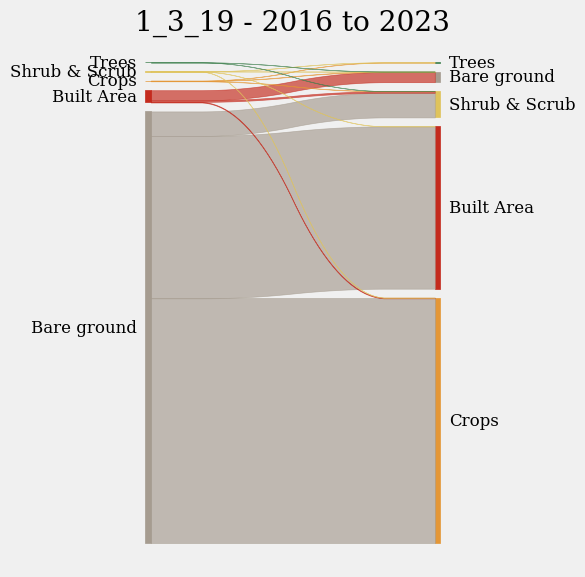

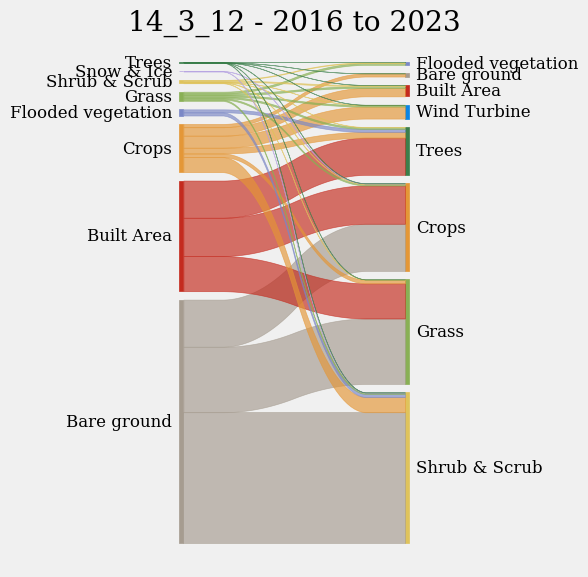

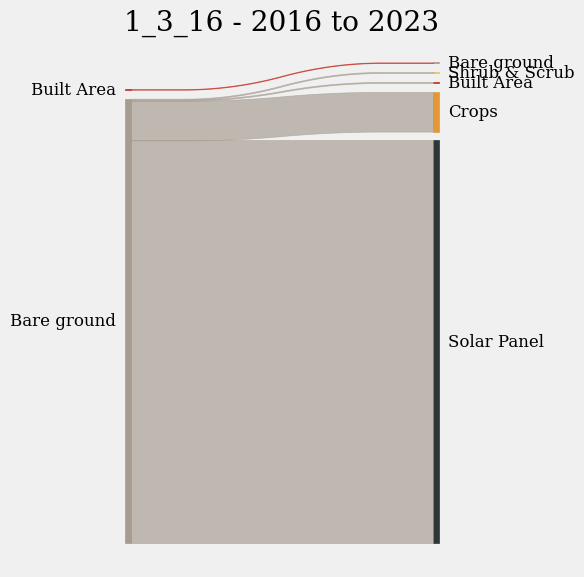

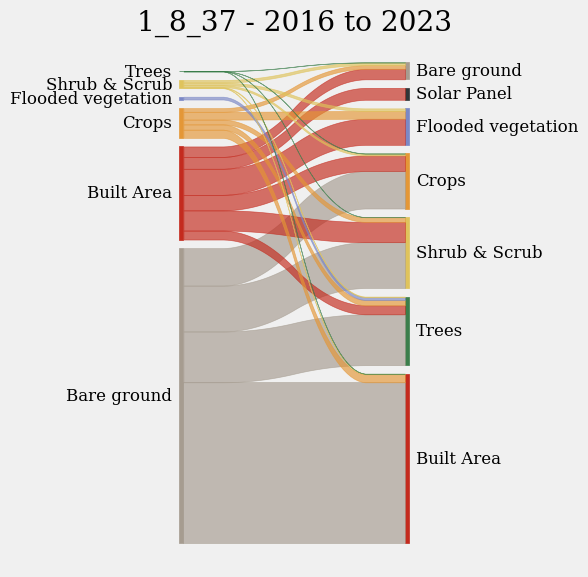

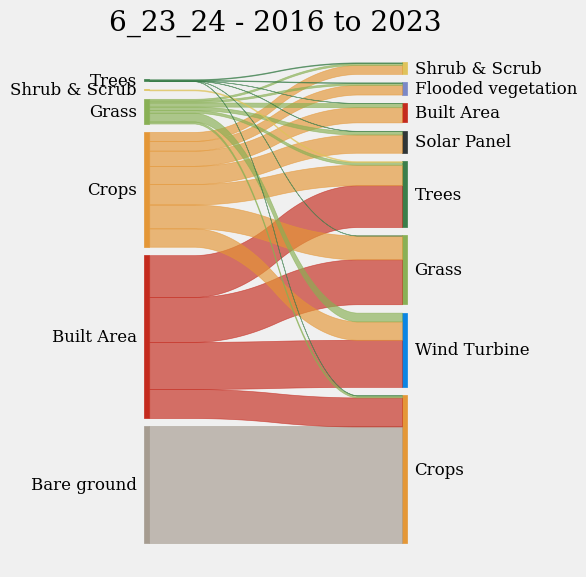

In [14]:
relevant_chips = {"DESERTIFICATION":[{"chipid":"1_3_19",
                                     "years":years,
                                     "country":"Israel"}],
                  "DEFORESTATION":[{"chipid":"14_3_12",
                                     "years":years,
                                     "country":"Denmark"}],
                  "SOLAR_EXPANSION":[{"chipid":"1_3_16",
                                     "years":years,
                                     "country":"Israel"}],
                  "URBAN_SPRAWL":[{"chipid":"1_8_37",
                                     "years":years,
                                     "country":"Israel"}],
                  "RENEWABLE_EXPANSION":[{"chipid":"6_23_24",
                                     "years":years,
                                     "country":"Netherlands"}]
                 }


for change_type,chips in relevant_chips.items():
    for params in chips:
        params["selected"] = change_type
        plot_chip(**params)


In [12]:
# OUTLIERS
outliers = pd.read_csv('../data/change_queries/outliers.csv')

cluster_country_mapping = {'0':'Israel','1':"Netherlands","2":"Estonia","3":"Denmark"}

for k,outlier_type in outliers[['country','cluster']].drop_duplicates().sort_values('cluster').iterrows():

    chosen_outlier = outliers[(outliers['country']==outlier_type['country']) & (outliers['cluster']==outlier_type['cluster'])].head(1)
    country = chosen_outlier['country'].values[0]
    chipid = chosen_outlier['chipid'].values[0]
    cluster = chosen_outlier['cluster'].values[0]
    print(f"Country : {country} - Chipid : {chipid} - outlier in cluster {cluster}, corresponding to {cluster_country_mapping[str(cluster)]}")
    
    plot_chip(chipid=chipid,
        years=years,
        country=country,
        selected="OUTLIERS")

Country : Denmark - Chipid : 13_4_7 - outlier in cluster 0, corresponding to Israel


  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/f06972113718ab62e39c4942257ccd9a-31582388ab8914a8edcae595e9ff41b3:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/OUTLIERS/13_4_7/support_files/sentinel2_image_897.tif
100%|██████████| 519k/519k [00:00<00:00, 725kB/s]
 12%|█▎        | 1/8 [00:36<04:14, 36.41s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/5c72c9eda14c7cc1016c108bb8229eb9-9fe7d713ba03a4297f29ef9c4d0a8aa6:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/OUTLIERS/13_4_7/support_files/sentinel2_image_25.tif
100%|██████████| 501k/501k [00:00<00:00, 914kB/s]
 25%|██▌       | 2/8 [01:15<03:48, 38.05s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/e89e4efe058bffe64fd15606463d4dce-d2ae26041ddc9813dd097371885f39e4:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/OUTLIERS/13_4_7/support_files/sentinel2_image_462.tif
100%|██████████| 521k/521k [00:00<00:00, 918kB/s]
 38%|███▊      | 3/8 [01:54<03:13, 38.61s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/31d797192925da379a4745d3f849c88b-40ee99b62f315fffbc099f0b674e9a07:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/selected/OUTLIERS/13_4_7/support_files/sentinel2_image_48.tif
100%|██████████| 517k/517k [00:00<00:00, 633kB/s]
 50%|█████     | 4/8 [02:32<02:32, 38.11s/it]

Getting LULC data
Getting satellite image


 50%|█████     | 4/8 [03:01<03:01, 45.42s/it]


KeyboardInterrupt: 

In [ ]:
relevant_chips = {"DESERTIFICATION":[{"chipid":"1_3_19",
                                     "years":years,
                                     "country":"Israel"}],
                  "DEFORESTATION":[{"chipid":"14_3_12",
                                     "years":years,
                                     "country":"Denmark"}],
                  "SOLAR_EXPANSION":[{"chipid":"1_3_16",
                                     "years":years,
                                     "country":"Israel"}],
                  "URBAN_SPRAWL":[{"chipid":"1_8_37",
                                     "years":years,
                                     "country":"Israel"}],
                  "RENEWABLE_EXPANSION":[{"chipid":"6_23_24",
                                     "years":years,
                                     "country":"Netherlands"}]
                 }


for change_type,chips in relevant_chips.items():
    for params in chips:
        params["selected"] = change_type
        plot_chip(**params)

In [ ]:
# Urbanization : 
### ISRAEL : "1_8_37"
### ISRAEL : "1_9_38"
### ISRAEL : "1_6_30"
### NETHERLANDS ; "6_12_17"

# Green Transition
### DENMARK : ""14_2_17""
### Netherlands : "6_13_17"
### Netherlands : "6_13_18"
### Netherlands : "6_14_18"
### Israel : "1_3_16"


# Desertification
### ISRAEL : "1_3_19" 
### ISRAEL : "1_2_19"

# Deforestation
### Denmark : ""14_3_12""
### Denmark : "14_2_16"
### ISRAEL : "1_7_25"
### ESTONIA : "6_11_18"

  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data


Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/9b15079d3504c19dbaba8b9ca7f94dea-fc014badf1a397b2c0d906427239bea3:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_19/support_files/sentinel2_image_694.tif
100%|██████████| 453k/453k [00:00<00:00, 642kB/s]
 12%|█▎        | 1/8 [01:00<07:03, 60.52s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/8798aa61320eae615d29436ecd1c7539-f3862bf6ef8d6ad2cb8433ee584e0be1:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_19/support_files/sentinel2_image_934.tif
100%|██████████| 451k/451k [00:00<00:00, 844kB/s]
 25%|██▌       | 2/8 [01:50<05:25, 54.29s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/a50f57eb05cb074f64a0ba36aefe2998-444a2a093228f1d9f02a214c69682826:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_19/support_files/sentinel2_image_202.tif
100%|██████████| 452k/452k [00:00<00:00, 669kB/s]
 38%|███▊      | 3/8 [02:30<03:59, 47.87s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/7eaf9d93371575c2d1cdf0da87dd276b-dd6b5b4a6225ec078753e8128912a420:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_19/support_files/sentinel2_image_798.tif
100%|██████████| 463k/463k [00:00<00:00, 511kB/s]
 50%|█████     | 4/8 [03:17<03:09, 47.42s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/85bf182409ca0312e919226cdccd8990-bb2a3be5a09ee740b03e22ad80371b30:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_19/support_files/sentinel2_image_586.tif
100%|██████████| 449k/449k [00:00<00:00, 682kB/s]
 62%|██████▎   | 5/8 [04:21<02:40, 53.50s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/dd8d49db09447c00157ac65994e538be-8133de24028eed854ec8c964bf2646fe:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_19/support_files/sentinel2_image_251.tif
100%|██████████| 446k/446k [00:00<00:00, 1.26MB/s]
 75%|███████▌  | 6/8 [05:06<01:41, 50.70s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/7d7f76407e2cbd87c75190d299c957d9-69350024986ee10622691ae70734e886:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_19/support_files/sentinel2_image_5.tif
100%|██████████| 453k/453k [00:00<00:00, 813kB/s]
 88%|████████▊ | 7/8 [05:44<00:46, 46.40s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/160a79f53c6ac093f5d1aea8b95d195e-97ed0c81efd8ccf0f187701cac9cbe6c:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_19/support_files/sentinel2_image_573.tif
100%|██████████| 450k/450k [00:00<00:00, 554kB/s]
100%|██████████| 8/8 [06:17<00:00, 47.18s/it]


Saving plot to ../plots/chips/1_3_19/1_3_19_sankey.png


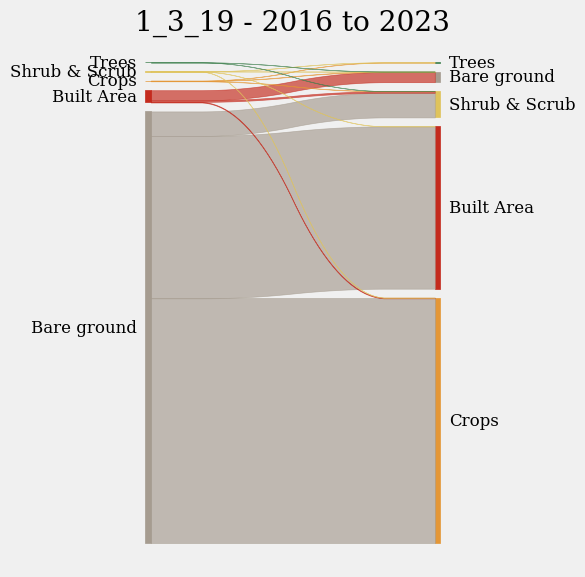

In [23]:
years = [str(year) for year in range(2016,2024)]
chipid = "1_3_19"
country = "Israel"

plot_chip(chipid=chipid,
          years=years,
          country=country)

In [24]:
years = [str(year) for year in range(2016,2024)]
chipid = "1_3_16"
country = "Israel"

plot_chip(chipid=chipid,
          years=years,
          country=country)

  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/083650a573f4bbdf0ef61dcbe22ef798-503bfc4d819c624bd279f1a658dd224a:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_16/support_files/sentinel2_image_938.tif
100%|██████████| 454k/454k [00:00<00:00, 1.07MB/s]
 12%|█▎        | 1/8 [00:38<04:27, 38.28s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/495f0028c5ec1721b2e1d264d92aa9c7-98722b7b5e41474718d9bbcb61f96a1e:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_16/support_files/sentinel2_image_203.tif
100%|██████████| 454k/454k [00:00<00:00, 462kB/s]
 25%|██▌       | 2/8 [01:17<03:51, 38.65s/it]

Getting LULC data


2024-05-17 17:16:19,040| ERROR   | Could not connect to gateway 89.150.135.220:11234 : Unable to connect to 89.150.135.220: [Errno 50] Network is down
 25%|██▌       | 2/8 [02:32<07:38, 76.35s/it]


BaseSSHTunnelForwarderError: Could not establish session to SSH gateway

  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/f52719691521e33aac7a471446a5297a-30d5465e5e6958b6e459856a74603b9e:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/14_3_12/support_files/sentinel2_image_200.tif
100%|██████████| 609k/609k [00:00<00:00, 871kB/s]
 12%|█▎        | 1/8 [00:53<06:12, 53.23s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/21812ca092c0025672f50eedff4ec1c8-533778a35c73c5c901bc0b6aa515c610:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/14_3_12/support_files/sentinel2_image_706.tif
100%|██████████| 574k/574k [00:00<00:00, 593kB/s]
 25%|██▌       | 2/8 [01:53<05:44, 57.45s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/dd4e6689032a38e9f8fcea6eea182d82-5938504a5367284b731726b9620f64a9:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/14_3_12/support_files/sentinel2_image_455.tif
100%|██████████| 516k/516k [00:00<00:00, 633kB/s]
 38%|███▊      | 3/8 [03:15<05:42, 68.55s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/2fb962ab41f405e6c1b42bd8ab383045-c123893089022e6ac2342545a63f4164:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/14_3_12/support_files/sentinel2_image_728.tif
100%|██████████| 510k/510k [00:00<00:00, 807kB/s]
 50%|█████     | 4/8 [04:13<04:18, 64.53s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/ffa0238ddbdca981aeb932fb7ab98194-26ef7052988d529e642420a412b57a1c:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/14_3_12/support_files/sentinel2_image_479.tif
100%|██████████| 620k/620k [00:00<00:00, 750kB/s]
 62%|██████▎   | 5/8 [05:01<02:55, 58.46s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/6a5f732aa970a9356cc387f1bff5cc04-b7769f22264d482f4b1d95594ec054e6:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/14_3_12/support_files/sentinel2_image_187.tif
100%|██████████| 534k/534k [00:00<00:00, 899kB/s]
 75%|███████▌  | 6/8 [05:57<01:55, 57.53s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/24232e55123a45380e5695d07a7b2454-241c564d5e5af8d3a063f6df92938b8c:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/14_3_12/support_files/sentinel2_image_480.tif
100%|██████████| 511k/511k [00:00<00:00, 734kB/s]
 88%|████████▊ | 7/8 [06:44<00:54, 54.32s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/2df167c6e4f38c7f9aa3574f0c07b950-7bb87dba75780617a64101a7bc7d1b02:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/14_3_12/support_files/sentinel2_image_752.tif
100%|██████████| 506k/506k [00:00<00:00, 635kB/s]
100%|██████████| 8/8 [07:47<00:00, 58.42s/it]


Saving plot to ../plots/chips/14_3_12/14_3_12_sankey.png


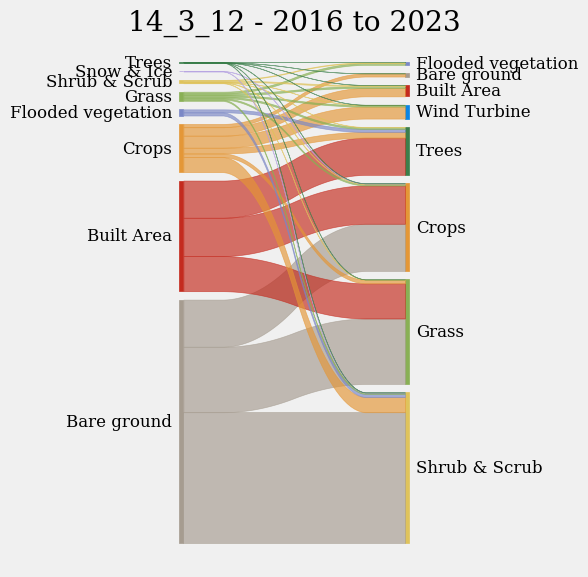

In [ ]:
years = [str(year) for year in range(2016,2024)]
chipid = "14_3_12"
country = "Denmark"

plot_chip(chipid=chipid,
          years=years,
          country=country)

  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/c1fa2a9f5e54c0436782728de6676839-03d32fce2408059ad41b3773b496197e:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_16/support_files/sentinel2_image_811.tif
100%|██████████| 454k/454k [00:00<00:00, 579kB/s]
 12%|█▎        | 1/8 [00:31<03:41, 31.70s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/f5292ee9dc0b401b1e183bf1816e720d-afd37bf830fbccb22448148d6b67340c:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_16/support_files/sentinel2_image_536.tif
100%|██████████| 454k/454k [00:01<00:00, 243kB/s]
 25%|██▌       | 2/8 [01:02<03:07, 31.29s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/e43c3419f65738711ee8b5d3e6411d42-2071e49afc376c7a701382b41a476302:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_16/support_files/sentinel2_image_847.tif
100%|██████████| 457k/457k [00:04<00:00, 95.4kB/s]
 38%|███▊      | 3/8 [01:41<02:52, 34.56s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/14d18f7996ea54bd135fd3e596489e96-ffb90991f5b1e1d475d7c6a228acab2b:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_16/support_files/sentinel2_image_174.tif
100%|██████████| 457k/457k [00:00<00:00, 859kB/s]
 50%|█████     | 4/8 [02:12<02:13, 33.45s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/9b7efdf6f9dd3da4a3a1763326f423b5-6f5881b3784de4346ca77bb2612c3fac:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_16/support_files/sentinel2_image_321.tif
100%|██████████| 453k/453k [00:01<00:00, 427kB/s]
 62%|██████▎   | 5/8 [02:44<01:38, 32.76s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/89de0ec4a2266952bfbd89ed2244f298-59d71b181e547d883b107c439ec13c91:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_16/support_files/sentinel2_image_826.tif
100%|██████████| 449k/449k [00:01<00:00, 269kB/s]
 75%|███████▌  | 6/8 [03:19<01:06, 33.42s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/a1e67270972e56eb4e9f4b0e8fe1c96a-6c4cdd58aacaf20edb3c0f87921ea7a6:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_16/support_files/sentinel2_image_91.tif
100%|██████████| 457k/457k [00:00<00:00, 600kB/s]
 88%|████████▊ | 7/8 [03:49<00:32, 32.58s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/858bbc71707a1b725865884eb7a38129-9422342e7d8dde67dbb885f38c016765:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_16/support_files/sentinel2_image_240.tif
100%|██████████| 464k/464k [00:00<00:00, 543kB/s]
100%|██████████| 8/8 [04:20<00:00, 32.54s/it]


Saving plot to ../plots/chips/1_3_16/1_3_16_sankey.png


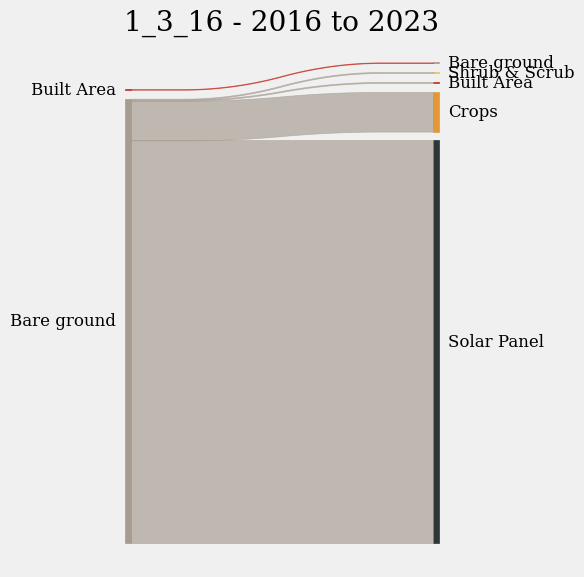

In [21]:
years = [str(year) for year in range(2016,2024)]
chipid = "1_3_16"
country = "Israel"

plot_chip(chipid=chipid,
          years=years,
          country=country)



  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/56162ed1d17910c07f466e98a0dfc50f-bd29a770c6cdfb8dcbf25c30dad613be:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_23_24/support_files/sentinel2_image_783.tif
100%|██████████| 515k/515k [00:00<00:00, 794kB/s]
 12%|█▎        | 1/8 [00:48<05:37, 48.18s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/609e1f8379a89605d03847b88360eb1b-acdb16c8c65e1cdd5924c9d5f95e4d7c:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_23_24/support_files/sentinel2_image_696.tif
100%|██████████| 515k/515k [00:00<00:00, 636kB/s]
 25%|██▌       | 2/8 [01:37<04:51, 48.66s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/2028a5cf0ad7e4043765783d2c356b93-86ee2641a9c6f434752b08841b788777:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_23_24/support_files/sentinel2_image_873.tif
100%|██████████| 519k/519k [00:00<00:00, 663kB/s]
 38%|███▊      | 3/8 [02:28<04:09, 49.88s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/c560f791adc984455a32bc45796fe92d-da4bdb7601d633afc1be21957e204d2c:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_23_24/support_files/sentinel2_image_87.tif
100%|██████████| 481k/481k [00:00<00:00, 843kB/s]
 50%|█████     | 4/8 [03:09<03:04, 46.18s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/3edf03f3f4a84fc157f1f6bfb3159854-4d2a2856ecccbcc1cf6a6ffff158fcbd:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_23_24/support_files/sentinel2_image_242.tif
100%|██████████| 474k/474k [00:00<00:00, 807kB/s]
 62%|██████▎   | 5/8 [03:52<02:15, 45.04s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/b8d829a0fa65fc29d44a1283ff36c063-8d685ffc82a42fc939f521a6bf762115:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_23_24/support_files/sentinel2_image_149.tif
100%|██████████| 490k/490k [00:00<00:00, 633kB/s]
 75%|███████▌  | 6/8 [04:33<01:27, 43.94s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/3e05045a9f3160aedb464aa33f75a272-1121c1a46b9673fc79136efc0e7cce75:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_23_24/support_files/sentinel2_image_618.tif
100%|██████████| 495k/495k [00:00<00:00, 758kB/s]
 88%|████████▊ | 7/8 [05:25<00:46, 46.51s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/f3c544e2e9266ef7423753a71bb2fe3b-a71fb70779d4ea99ced1c5d840e0112e:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_23_24/support_files/sentinel2_image_217.tif
100%|██████████| 492k/492k [00:00<00:00, 768kB/s]
100%|██████████| 8/8 [06:17<00:00, 47.13s/it]


Saving plot to ../plots/chips/6_23_24/6_23_24_sankey.png


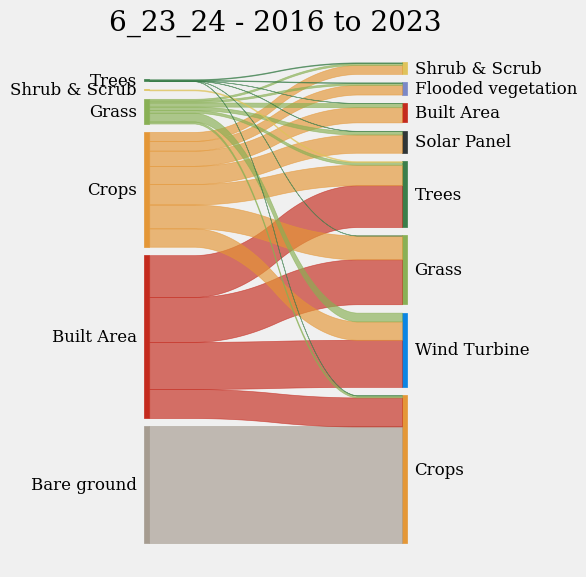

In [18]:
years = [str(year) for year in range(2016,2024)]
chipid = "6_23_24"
country = "Netherlands"

plot_chip(chipid=chipid,
          years=years,
          country=country)



  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/3b006ef1f8662430d4c8cf93871c4c94-c44bcdca484c959c6fc669e9e521e14c:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_16_13/support_files/sentinel2_image_6.tif
100%|██████████| 618k/618k [00:00<00:00, 722kB/s]
 12%|█▎        | 1/8 [00:46<05:28, 46.86s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/82d5a9d01280bea4b31fe5b657a0b18d-e682f8b6e39df411404a37dd823929e2:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_16_13/support_files/sentinel2_image_459.tif
100%|██████████| 638k/638k [00:00<00:00, 1.09MB/s]
 25%|██▌       | 2/8 [01:30<04:30, 45.01s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/f96e1a3a53f59deac2f2d8c7edfd9ddc-02ce060d82b840cfa459416375db3632:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_16_13/support_files/sentinel2_image_288.tif
100%|██████████| 555k/555k [00:00<00:00, 881kB/s]
 38%|███▊      | 3/8 [02:12<03:38, 43.75s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/f382247c3a1db855578e6ef8f9923102-cb92322cad699be6d4c5e8f2d724f2b1:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_16_13/support_files/sentinel2_image_580.tif
100%|██████████| 633k/633k [00:00<00:00, 735kB/s]
 50%|█████     | 4/8 [16:45<24:43, 370.98s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/5f23263ec84fab4399e54c7c49155e3e-e41fa07f73c4f8ab833c6e60fbfef47a:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_16_13/support_files/sentinel2_image_113.tif
100%|██████████| 512k/512k [00:00<00:00, 766kB/s]
 62%|██████▎   | 5/8 [17:34<12:44, 254.87s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/5557755de93a8e7289c32d714b1a0ab7-d9ed20179392a45f0cde7b3684d69dc5:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_16_13/support_files/sentinel2_image_195.tif
100%|██████████| 662k/662k [00:01<00:00, 424kB/s]
 75%|███████▌  | 6/8 [18:11<06:01, 180.86s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/3b41d6c0cfc4b1a3c1f14ec30eeddfb8-2edcfb137492a12d40773d6c65fef4cb:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_16_13/support_files/sentinel2_image_250.tif
100%|██████████| 658k/658k [00:00<00:00, 948kB/s]
 88%|████████▊ | 7/8 [18:56<02:16, 136.37s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/2ddaedf0f63a848174b14aa940ced0d2-05eae825cb0a7e6711d58ba7eb5d12e0:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_16_13/support_files/sentinel2_image_201.tif
100%|██████████| 636k/636k [00:00<00:00, 963kB/s]
100%|██████████| 8/8 [19:27<00:00, 145.95s/it]


Saving plot to ../plots/chips/6_16_13/6_16_13_sankey.png


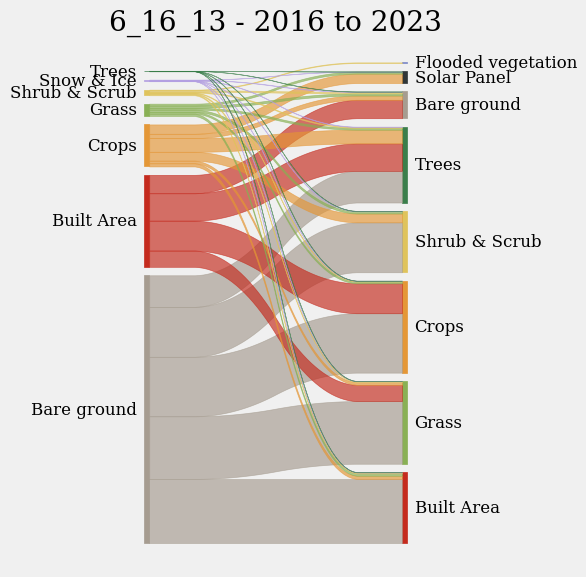

In [19]:
# LAND COMPETITION 
years = [str(year) for year in range(2016,2024)]
chipid = "6_16_13"
country = "Estonia"

plot_chip(chipid=chipid,
          years=years,
          country=country)

  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/8b942afa4021bd63bb8d28bcfe970423-e4b02c86c1e1959a892c16f5e86f887a:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_14_5/support_files/sentinel2_image_237.tif
100%|██████████| 431k/431k [00:00<00:00, 731kB/s]
 12%|█▎        | 1/8 [00:52<06:05, 52.15s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/e8ec103bb83397e471100fd567b39800-b856bd00a7c7618efb3814015987fc4a:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_14_5/support_files/sentinel2_image_894.tif
100%|██████████| 394k/394k [00:00<00:00, 642kB/s]
 25%|██▌       | 2/8 [01:29<04:21, 43.65s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/d592b22641dc5fcbe18074b979be490e-f8f1417bcfd6293356ba734a4b55cc4b:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_14_5/support_files/sentinel2_image_116.tif
100%|██████████| 394k/394k [00:00<00:00, 677kB/s]
 38%|███▊      | 3/8 [02:15<03:42, 44.48s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/7b7fbd46808c32bb9c4e431e136d3119-283af0fe54be100b12c830a0242cf311:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_14_5/support_files/sentinel2_image_658.tif
100%|██████████| 407k/407k [00:00<00:00, 633kB/s]
 50%|█████     | 4/8 [03:02<03:02, 45.52s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/d9cda32bbc37f26051bc392c54ddda4d-05fe830731148752194d39d4251cacad:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_14_5/support_files/sentinel2_image_566.tif
100%|██████████| 404k/404k [00:00<00:00, 656kB/s]
 62%|██████▎   | 5/8 [03:44<02:13, 44.43s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/faffa99093f2ece8214704d9f7f860ca-4833574e65e98311505d42388deef0eb:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_14_5/support_files/sentinel2_image_881.tif
100%|██████████| 516k/516k [00:00<00:00, 734kB/s]
 75%|███████▌  | 6/8 [04:31<01:29, 44.99s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/9f3d3d39053e0d6d154e3734b9dff1c2-631c49bbdca6503081961d69d0b77623:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_14_5/support_files/sentinel2_image_144.tif
100%|██████████| 400k/400k [00:00<00:00, 623kB/s]
 88%|████████▊ | 7/8 [05:16<00:45, 45.16s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/3c1de10f62bd1c192768895d06030da8-a4775eed653e0718a163ba2d583923e0:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_14_5/support_files/sentinel2_image_624.tif
100%|██████████| 399k/399k [00:00<00:00, 561kB/s]
100%|██████████| 8/8 [06:01<00:00, 45.18s/it]


Saving plot to ../plots/chips/6_14_5/6_14_5_sankey.png


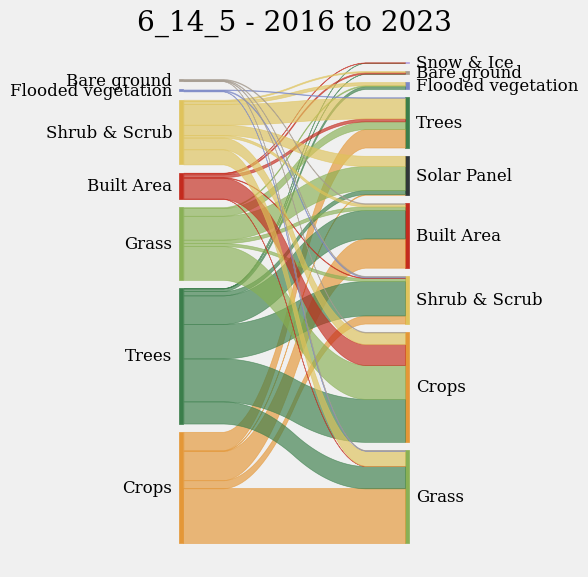

In [23]:
# LAND COMPETITION 
years = [str(year) for year in range(2016,2024)]
chipid = "6_14_5"
country = "Netherlands"

plot_chip(chipid=chipid,
          years=years,
          country=country)

In [ ]:
# Desertification
### ISRAEL : "1_3_19" 
### ISRAEL : "1_2_19"

# Deforestation
### Denmark : ""14_3_12""
### Denmark : "14_2_16"
### ISRAEL : "1_7_25"
### ESTONIA : "6_11_18"

  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/e5f813bf02425578b36ddfe2b6c8c1df-aec5a9e3c2c5e64da95c7fd084b8f416:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_19/support_files/sentinel2_image_852.tif
100%|██████████| 453k/453k [00:00<00:00, 696kB/s]
 12%|█▎        | 1/8 [00:31<03:38, 31.16s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/b5fc67180df3d640ca9175adb4a691fd-23741cb39bdf9b82027b7991410ea57e:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_19/support_files/sentinel2_image_473.tif
100%|██████████| 451k/451k [00:00<00:00, 679kB/s]
 25%|██▌       | 2/8 [01:02<03:06, 31.07s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/e721f08ac4aecc18d4a165d27b2e261e-9858fee4b5630440071315dd345540b2:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_19/support_files/sentinel2_image_298.tif
100%|██████████| 452k/452k [00:00<00:00, 694kB/s]
 38%|███▊      | 3/8 [01:32<02:33, 30.67s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/1e8ca70a518fafba9c1efa52017fb33b-14d0dcda34a85072da5f64f48c191ca4:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_19/support_files/sentinel2_image_947.tif
100%|██████████| 463k/463k [00:00<00:00, 702kB/s]
 50%|█████     | 4/8 [02:01<02:00, 30.10s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/15bbbfcce173a70d7a1019f0ac29f091-a37609b2cd9b8b54dd1c83e4bd1658cf:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_19/support_files/sentinel2_image_320.tif
100%|██████████| 449k/449k [00:00<00:00, 669kB/s]
 62%|██████▎   | 5/8 [02:30<01:29, 29.84s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/93da535abc017d23c647ca50d2fc9900-9cd8c034091ee85884698d54929a9a4d:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_19/support_files/sentinel2_image_335.tif
100%|██████████| 446k/446k [00:00<00:00, 672kB/s]
 75%|███████▌  | 6/8 [03:02<01:00, 30.34s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/0a025ccc733c15d800a3f1317870b6e7-93e467645a23b17a5f14a9382c4f1cd2:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_19/support_files/sentinel2_image_163.tif
100%|██████████| 453k/453k [00:00<00:00, 683kB/s]
 88%|████████▊ | 7/8 [03:32<00:30, 30.23s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/7ecdbdeadbfcaf6bf66c17a2cbd251ed-0e4f1f2119b20c4669e0b59c62a34a01:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_19/support_files/sentinel2_image_702.tif
100%|██████████| 450k/450k [00:00<00:00, 682kB/s]
100%|██████████| 8/8 [04:00<00:00, 30.02s/it]


Saving plot to ../plots/chips/1_3_19/1_3_19_sankey.png


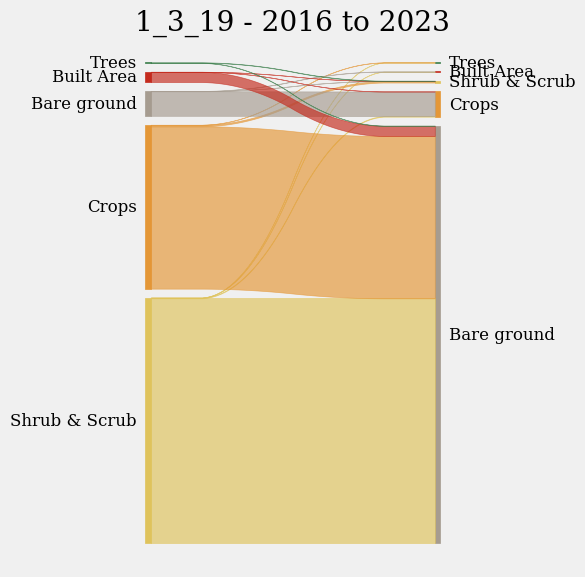

In [12]:
years = [str(year) for year in range(2016,2024)]
chipid = "1_3_19"
country = "Israel"

plot_chip(chipid=chipid,
          years=years,
          country=country)

  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/71aea72fb673b4d5e92810ee40ff39cf-e9986b487679333274ae1a5ebfda4dea:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/14_3_12/support_files/sentinel2_image_92.tif
100%|██████████| 609k/609k [00:01<00:00, 585kB/s]
 12%|█▎        | 1/8 [00:45<05:18, 45.54s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/5a5da60b49ad8198995027e61d7c0462-f94625f7a4d750fbb42f737f55646e7f:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/14_3_12/support_files/sentinel2_image_822.tif
100%|██████████| 574k/574k [00:00<00:00, 784kB/s]
 25%|██▌       | 2/8 [01:35<04:49, 48.28s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/794f42481aee68cb911efa4c2f0d0c5c-42cdfe284fea7aab910a537fda982647:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/14_3_12/support_files/sentinel2_image_989.tif
100%|██████████| 516k/516k [00:00<00:00, 812kB/s]
 38%|███▊      | 3/8 [02:19<03:50, 46.02s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/c1dff239d24f9500792fefbf7f719533-4993647e2fa9929ea46d21906803e43d:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/14_3_12/support_files/sentinel2_image_508.tif
100%|██████████| 510k/510k [00:00<00:00, 794kB/s]
 50%|█████     | 4/8 [03:04<03:02, 45.62s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/57bfdfbdfd79ec8ee34b2fd44a933325-f67368b86c6b834900866455d7f4956d:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/14_3_12/support_files/sentinel2_image_138.tif
100%|██████████| 620k/620k [00:00<00:00, 819kB/s]
 62%|██████▎   | 5/8 [03:52<02:20, 46.81s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/06a5400f2020ef55baf099f56c126e27-3c192ea5864a0d44135be9f3983cb207:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/14_3_12/support_files/sentinel2_image_584.tif
100%|██████████| 534k/534k [00:00<00:00, 777kB/s]
 75%|███████▌  | 6/8 [04:35<01:30, 45.45s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/d8e9047f8bfc84c37d8316ae0f374b2c-ecf122b07194f1bedd3e2e173d3a3a80:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/14_3_12/support_files/sentinel2_image_616.tif
100%|██████████| 511k/511k [00:00<00:00, 748kB/s]
 88%|████████▊ | 7/8 [05:19<00:45, 45.03s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/8f29d5c0a0576568d0bbb325e5cd3da5-aacfcca899113f146bc93c4308a82f15:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/14_3_12/support_files/sentinel2_image_800.tif
100%|██████████| 506k/506k [00:00<00:00, 751kB/s]
100%|██████████| 8/8 [06:03<00:00, 45.40s/it]


Saving plot to ../plots/chips/14_3_12/14_3_12_sankey.png


  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/8ec1674159e778d77e99f69c7164d434-a2d7e4ca80b21173dd278f0a33704633:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/14_2_16/support_files/sentinel2_image_824.tif
100%|██████████| 661k/661k [00:00<00:00, 906kB/s]
 12%|█▎        | 1/8 [00:39<04:34, 39.20s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/b1876c487f4d54294af26b5cbd8c7c2a-8b5b9b60cdaee04d81905c1218606710:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/14_2_16/support_files/sentinel2_image_266.tif
100%|██████████| 607k/607k [00:00<00:00, 939kB/s]
 25%|██▌       | 2/8 [01:12<03:35, 35.85s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/2366d0e3941ed5cc20698bd7295420e2-b878301001664203c7875c5d09a294c4:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/14_2_16/support_files/sentinel2_image_387.tif
100%|██████████| 530k/530k [00:00<00:00, 791kB/s]
 38%|███▊      | 3/8 [01:44<02:50, 34.20s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/877b0eadbf2ccf23e7cc6ddb45f9f4e1-963edff5594e10700ab1e4a72caac8d3:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/14_2_16/support_files/sentinel2_image_463.tif
100%|██████████| 511k/511k [00:00<00:00, 726kB/s]
 50%|█████     | 4/8 [02:18<02:15, 33.99s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/909b697e7b08137f0935b43393dc75d1-55797bf4780af7a65e340c90e3ba0568:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/14_2_16/support_files/sentinel2_image_338.tif
100%|██████████| 608k/608k [00:01<00:00, 505kB/s]
 62%|██████▎   | 5/8 [02:56<01:46, 35.36s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/c7ff06acf85fa443108478e520480cf7-70efa18dffcb9047c38dbe70a8687ed3:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/14_2_16/support_files/sentinel2_image_541.tif
100%|██████████| 573k/573k [00:00<00:00, 848kB/s]
 75%|███████▌  | 6/8 [03:29<01:09, 34.72s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/27f22efc42973aa242d5cc14fda42597-03f991b5a27cf79ee78859bac62db4dd:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/14_2_16/support_files/sentinel2_image_554.tif
100%|██████████| 508k/508k [00:00<00:00, 771kB/s]
 88%|████████▊ | 7/8 [04:02<00:33, 33.97s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/b8b05d5d67de068de7b6a15b8dc0a94c-d076f66d6dc9e75c7f3417145c110938:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/14_2_16/support_files/sentinel2_image_833.tif
100%|██████████| 508k/508k [00:00<00:00, 789kB/s]
100%|██████████| 8/8 [04:37<00:00, 34.68s/it]


Saving plot to ../plots/chips/14_2_16/14_2_16_sankey.png


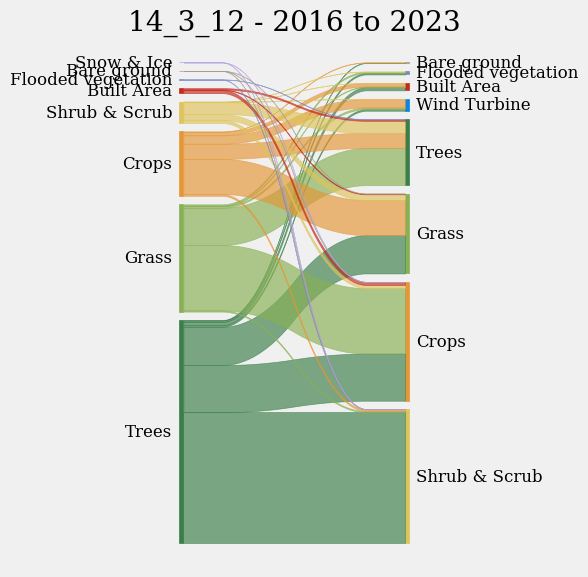

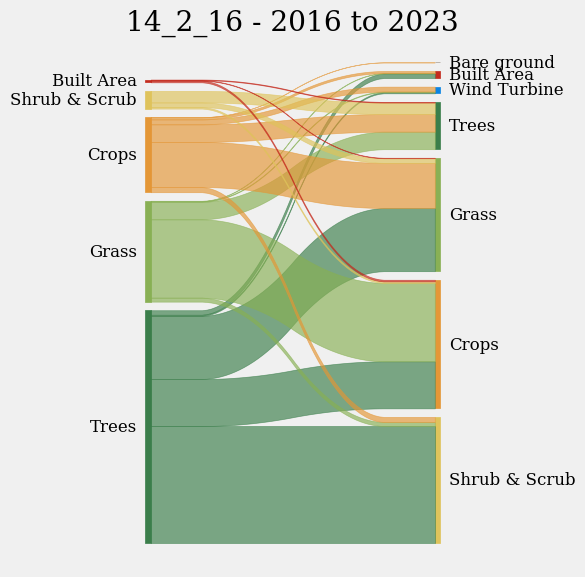

In [14]:
years = [str(year) for year in range(2016,2024)]
chipids = ["14_3_12","14_2_16"]
country = "Denmark"
for chipid in chipids:
    plot_chip(chipid=chipid,
            years=years,
            country=country)

  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/dbbf909f9c8ea4c03896e6528abee029-f9fe609f78fa533329e71a17299b5c8e:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_11_18/support_files/sentinel2_image_697.tif
100%|██████████| 625k/625k [00:00<00:00, 909kB/s]
 12%|█▎        | 1/8 [00:31<03:43, 31.91s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/36fe774dc0a304fa1493a80a584fca27-2cfc570ce071979e01fb77f49d9cad09:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_11_18/support_files/sentinel2_image_674.tif
100%|██████████| 629k/629k [00:00<00:00, 820kB/s]
 25%|██▌       | 2/8 [01:00<03:00, 30.07s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/9336e6b092d4df82c149c25b2f955745-a0e981a41bcf407b79f4a31a5f5c22b2:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_11_18/support_files/sentinel2_image_512.tif
100%|██████████| 652k/652k [00:00<00:00, 892kB/s]
 38%|███▊      | 3/8 [01:32<02:35, 31.06s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/3ab9d8b36bf725d15ccd768028438012-42d7467daba5bf0bb4ce5e68d0d374d5:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_11_18/support_files/sentinel2_image_643.tif
100%|██████████| 648k/648k [00:00<00:00, 884kB/s]
 50%|█████     | 4/8 [02:06<02:08, 32.22s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/be749fd16c494494693bcddcf1ae591f-e01083c0964010bc4b602a3c88e7c6f8:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_11_18/support_files/sentinel2_image_44.tif
100%|██████████| 586k/586k [00:00<00:00, 837kB/s]
 62%|██████▎   | 5/8 [02:39<01:36, 32.26s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/9b1db903e53dc9448bf4e2f9c6843403-09c3080e044673ef95e066181ef112cc:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_11_18/support_files/sentinel2_image_848.tif
100%|██████████| 651k/651k [00:00<00:00, 943kB/s]
 75%|███████▌  | 6/8 [03:08<01:02, 31.17s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/1c84509b5be711076bdae1adfb35da0b-c42441910d89589148609fe3eaf5d19b:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_11_18/support_files/sentinel2_image_448.tif
100%|██████████| 653k/653k [00:00<00:00, 855kB/s]
 88%|████████▊ | 7/8 [03:38<00:30, 30.69s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/f779e068e32b2ec2271785bf09fa7083-142e1b697a1bfdf7dcf8f1bc796a6287:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_11_18/support_files/sentinel2_image_649.tif
100%|██████████| 614k/614k [00:00<00:00, 882kB/s]
100%|██████████| 8/8 [04:08<00:00, 31.11s/it]


Saving plot to ../plots/chips/6_11_18/6_11_18_sankey.png


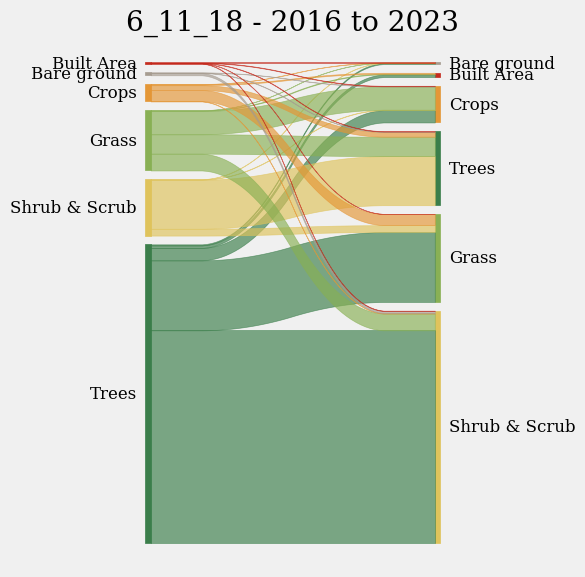

In [15]:
years = [str(year) for year in range(2016,2024)]
chipid = "6_11_18"
country = "Estonia"

plot_chip(chipid=chipid,
          years=years,
          country=country)

  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/a6893b52ba4606384f54f989bc39caf1-f15419590d55042a44b5a8d8ce7e94b9:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_14_18/support_files/sentinel2_image_244.tif
100%|██████████| 481k/481k [00:00<00:00, 726kB/s]
 12%|█▎        | 1/8 [00:47<05:34, 47.76s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/2443a2a0175606142a352955bdecf99f-b3411428b47b48c15176b614d4af559e:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_14_18/support_files/sentinel2_image_801.tif
100%|██████████| 489k/489k [00:00<00:00, 756kB/s]
 25%|██▌       | 2/8 [03:15<10:41, 106.85s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/3d0617a954447c63ca15b4ce657ede75-d99307be8d3371c25500f28948da5392:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_14_18/support_files/sentinel2_image_204.tif
100%|██████████| 502k/502k [00:00<00:00, 654kB/s]
 38%|███▊      | 3/8 [03:59<06:29, 77.85s/it] 

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/49465bc1d2d46b4de870d6e1e39f7ad4-5705e2f4d881dfcb4eb7724c311bfe95:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_14_18/support_files/sentinel2_image_881.tif
100%|██████████| 539k/539k [00:00<00:00, 726kB/s]
 50%|█████     | 4/8 [04:45<04:21, 65.40s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/81733954da233abe735234a6355a2b1a-ee49414068989e72f956b9c8ba777a72:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_14_18/support_files/sentinel2_image_480.tif
100%|██████████| 492k/492k [00:00<00:00, 764kB/s]
 62%|██████▎   | 5/8 [05:32<02:56, 58.75s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/3df4e816f43e516f669754f43ab20957-ef5309a1ebcd4611b4b67f9d3f255da9:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_14_18/support_files/sentinel2_image_479.tif
100%|██████████| 495k/495k [00:00<00:00, 746kB/s]
 75%|███████▌  | 6/8 [06:27<01:55, 57.56s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/06bd55c7fbb3b1b65fbae20f3a6c93ab-d3b25c61b3826c677684aa59c52c9d0b:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_14_18/support_files/sentinel2_image_977.tif
100%|██████████| 491k/491k [00:00<00:00, 724kB/s]
 88%|████████▊ | 7/8 [07:15<00:54, 54.31s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/076fa1d96b962fe778d0b8f2a678b0d3-ef3b541dc9f36e97381e6d474521d92d:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_14_18/support_files/sentinel2_image_417.tif
100%|██████████| 470k/470k [00:00<00:00, 623kB/s]
100%|██████████| 8/8 [08:05<00:00, 60.65s/it]


Saving plot to ../plots/chips/6_14_18/6_14_18_sankey.png


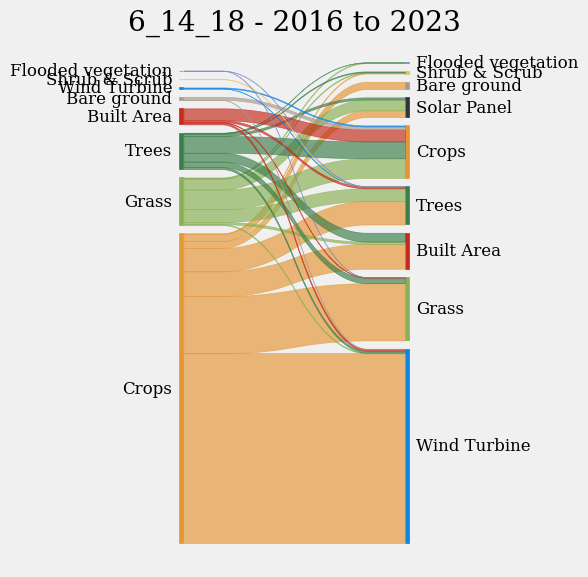

In [16]:
years = [str(year) for year in range(2016,2024)]
chipid = "6_14_18"
country = "Netherlands"

plot_chip(chipid=chipid,
          years=years,
          country=country)

  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/0419622fd8afc999041e875a271d2f59-1379a0db14de7b851439304444384abd:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_10_19/support_files/sentinel2_image_798.tif
100%|██████████| 627k/627k [00:00<00:00, 850kB/s]
 12%|█▎        | 1/8 [00:34<04:00, 34.43s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/df767e79983c21ee979c69e60cc78e72-5b3b1c9c14d510f0409f51fbd1646527:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_10_19/support_files/sentinel2_image_626.tif
100%|██████████| 640k/640k [00:00<00:00, 827kB/s]
 25%|██▌       | 2/8 [01:03<03:08, 31.41s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/02567742a99375d9386c1cad44d85a62-2eb1180d9177be4b74cef50f3c6fa2c4:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_10_19/support_files/sentinel2_image_345.tif
100%|██████████| 662k/662k [00:00<00:00, 894kB/s]
 38%|███▊      | 3/8 [01:34<02:35, 31.18s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/0756a22009be7b5aaac700f73ede418d-130cf32040af493cbe48316c92d459ab:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_10_19/support_files/sentinel2_image_279.tif
100%|██████████| 643k/643k [00:00<00:00, 879kB/s]
 50%|█████     | 4/8 [02:04<02:02, 30.51s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/1feace06d978b3513570176ffa70169d-9bee1c3ee155c159dda6178cbe1b3c2d:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_10_19/support_files/sentinel2_image_71.tif
100%|██████████| 515k/515k [00:00<00:00, 740kB/s]
 62%|██████▎   | 5/8 [02:37<01:35, 31.67s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/ba3fee3a5cea4229a26a77dfe0a750e9-322268d79f11963d5a929ab4ffda7e8c:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_10_19/support_files/sentinel2_image_784.tif
100%|██████████| 653k/653k [00:00<00:00, 883kB/s]
 75%|███████▌  | 6/8 [03:07<01:02, 31.04s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/653794aebffa4b6463452d6a54bc0d23-f459e2bd499828df9faa3f0053bbc120:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_10_19/support_files/sentinel2_image_330.tif
100%|██████████| 655k/655k [00:00<00:00, 816kB/s]
 88%|████████▊ | 7/8 [03:41<00:31, 31.86s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/4cd76b6aed1909fa80c7482bd75fc579-b34735452b1f28e6b9f7d9aaa75cc4c4:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_10_19/support_files/sentinel2_image_158.tif
100%|██████████| 622k/622k [00:00<00:00, 925kB/s]
100%|██████████| 8/8 [04:12<00:00, 31.59s/it]


Saving plot to ../plots/chips/6_10_19/6_10_19_sankey.png


  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/f2f246e7470b630839365c4e132ccb83-2b4eacc9c79460e38726739aba4e9e90:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_11_19/support_files/sentinel2_image_799.tif
100%|██████████| 600k/600k [00:00<00:00, 866kB/s]
 12%|█▎        | 1/8 [00:31<03:41, 31.69s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/7e13a6172320c20a61b3360636fedc7d-f1953012a500967118de67e91eba8784:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_11_19/support_files/sentinel2_image_538.tif
100%|██████████| 626k/626k [00:00<00:00, 958kB/s]
 25%|██▌       | 2/8 [01:04<03:15, 32.54s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/c4ed13e86bbb359dd033717afbc5a001-21a7b5b513959cf05f6bcc4d4ace4734:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_11_19/support_files/sentinel2_image_63.tif
100%|██████████| 651k/651k [00:00<00:00, 1.01MB/s]
 38%|███▊      | 3/8 [01:38<02:45, 33.10s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/2d8eb22731805a93aa1a2758d00648e9-ae413191b344481f7d72c41a7ab7da50:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_11_19/support_files/sentinel2_image_189.tif
100%|██████████| 643k/643k [00:00<00:00, 871kB/s]
 50%|█████     | 4/8 [02:10<02:10, 32.64s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/b1ad7e2f5ad05673e8c070b5e48a9c39-548643247da61f6ec54dd4d881e97c51:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_11_19/support_files/sentinel2_image_427.tif
100%|██████████| 510k/510k [00:00<00:00, 741kB/s]
 62%|██████▎   | 5/8 [02:40<01:35, 31.81s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/5d5e677825519cf5642407a36f759b3f-b80c1dd64d36ff47e7fdca7c7b90c911:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_11_19/support_files/sentinel2_image_947.tif
100%|██████████| 644k/644k [00:00<00:00, 731kB/s]
 75%|███████▌  | 6/8 [03:12<01:03, 31.77s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/0a25bc3bd06afcc0b89d680178751780-ac478ea2318e2df5d2ffa3328b6d16f4:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_11_19/support_files/sentinel2_image_787.tif
100%|██████████| 643k/643k [00:00<00:00, 915kB/s]
 88%|████████▊ | 7/8 [03:44<00:31, 31.69s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/3bb4e0a1681ad05716e17f797d34fd79-b9147d4200d923872f76edc10bac8ade:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_11_19/support_files/sentinel2_image_213.tif
100%|██████████| 610k/610k [00:00<00:00, 819kB/s]
100%|██████████| 8/8 [04:20<00:00, 32.57s/it]


Saving plot to ../plots/chips/6_11_19/6_11_19_sankey.png


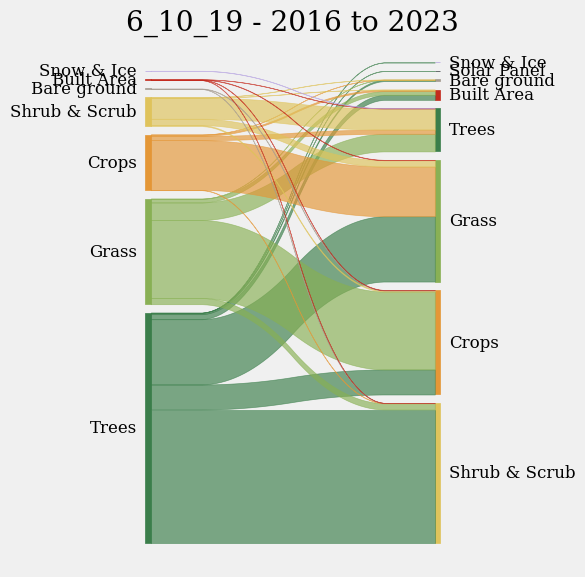

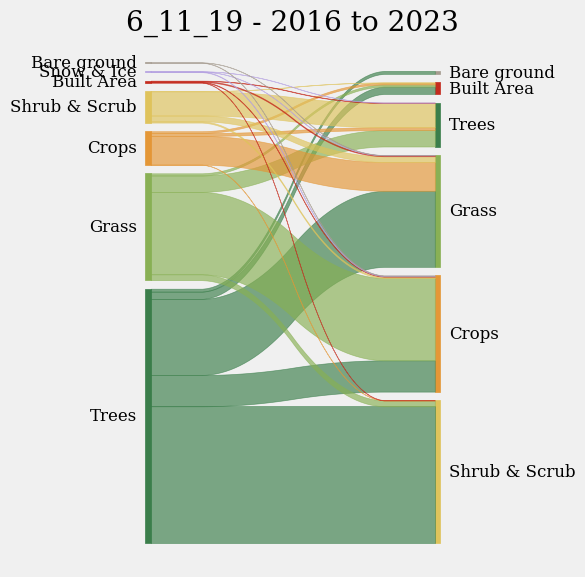

In [17]:
# ESTONIA 
years = [str(year) for year in range(2016,2024)]
chipids = ["6_10_19","6_11_19"]
country = "Estonia"
for chipid in chipids:
    plot_chip(chipid=chipid,
            years=years,
            country=country)

  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/60632c82a959b8e0b979ec5115ac0793-0193b9b44edf81741b728231a70fdff1:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_23_26/support_files/sentinel2_image_804.tif
100%|██████████| 509k/509k [00:01<00:00, 481kB/s]
 12%|█▎        | 1/8 [00:46<05:27, 46.86s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/b2be0eccf852d088ed63c5b91f89a059-2f15aeae7f939e9906121ee5819bc74c:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_23_26/support_files/sentinel2_image_153.tif
100%|██████████| 568k/568k [00:00<00:00, 925kB/s]
 25%|██▌       | 2/8 [01:37<04:53, 49.00s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/5d6a32b269e6569c5f96fbe326796488-95a2cda91f6c2aaeaff33a18da744ecc:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_23_26/support_files/sentinel2_image_105.tif
100%|██████████| 513k/513k [00:00<00:00, 852kB/s]
 38%|███▊      | 3/8 [02:18<03:47, 45.43s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/8532eaa171d92ae0deaa02cd7952b33e-d9e10cabdad822b5fd24d4bae1db89a9:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_23_26/support_files/sentinel2_image_215.tif
100%|██████████| 479k/479k [00:00<00:00, 752kB/s]
 50%|█████     | 4/8 [03:04<03:01, 45.49s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/dc81ee49a7f6300f25bf327a30ca5e05-406c7e4a3e9f58e9d37810cf541131cd:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_23_26/support_files/sentinel2_image_237.tif
100%|██████████| 479k/479k [00:00<00:00, 779kB/s]
 62%|██████▎   | 5/8 [03:54<02:21, 47.22s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/4324e88e244af8c08e0ad84b81feaec6-6b942afce873bc5e2ac93c3e5147197d:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_23_26/support_files/sentinel2_image_843.tif
100%|██████████| 497k/497k [00:00<00:00, 804kB/s]
 75%|███████▌  | 6/8 [04:42<01:34, 47.36s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/cf771f93384c229d20f4a5fdf48e4485-d2d36bbb60b5fe9cf428bd15105d9d3a:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_23_26/support_files/sentinel2_image_976.tif
100%|██████████| 490k/490k [00:00<00:00, 697kB/s]
 88%|████████▊ | 7/8 [05:30<00:47, 47.63s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/22f275a9a70ed94fb2594f2f6f730354-d7f862f6a9aaaa6fb6da1f85bd92fb7b:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_23_26/support_files/sentinel2_image_911.tif
100%|██████████| 489k/489k [00:00<00:00, 548kB/s]
100%|██████████| 8/8 [06:12<00:00, 46.61s/it]


Saving plot to ../plots/chips/6_23_26/6_23_26_sankey.png


  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/60b95e0b4241097332df0b7ddf38d871-5e158611d6b5b8fb9cbae6c78c41e7ce:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_23_24/support_files/sentinel2_image_667.tif
100%|██████████| 515k/515k [00:00<00:00, 705kB/s]
 12%|█▎        | 1/8 [01:01<07:11, 61.67s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/609dbdaa4c90aaf880c68703acb04153-fb1c454187eb4cb55d30f5939893dd47:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_23_24/support_files/sentinel2_image_657.tif
100%|██████████| 515k/515k [00:00<00:00, 794kB/s]
 25%|██▌       | 2/8 [01:45<05:05, 50.93s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/e332da3c16d5a12a4fdb03844bace11e-3b2e53a401dab3d9a6f830b7492aa8a0:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_23_24/support_files/sentinel2_image_815.tif
100%|██████████| 519k/519k [00:00<00:00, 734kB/s]
 38%|███▊      | 3/8 [02:24<03:48, 45.61s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/425c8cc25a16ceadeda92ed97f963882-8869ceae32fcc6f966e0b7444bb67650:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_23_24/support_files/sentinel2_image_96.tif
100%|██████████| 481k/481k [00:00<00:00, 749kB/s]
 50%|█████     | 4/8 [03:03<02:51, 42.88s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/2c98e48fbf10c8215f745f1c0b0dd176-019e1cf7bef29e212c69fbf7b9da02c0:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_23_24/support_files/sentinel2_image_379.tif
100%|██████████| 474k/474k [00:00<00:00, 703kB/s]
 62%|██████▎   | 5/8 [03:41<02:03, 41.11s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/ee06d8e6c4ddd94c4ceed0a0610c2c0d-c6b939729fd138e632d66dfc05a9ac44:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_23_24/support_files/sentinel2_image_923.tif
100%|██████████| 490k/490k [00:00<00:00, 797kB/s]
 75%|███████▌  | 6/8 [04:16<01:18, 39.19s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/ca6eb974a708fd4a7169b9475ee7c497-a55ccc09084aa0ac4f8afb69a734b82d:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_23_24/support_files/sentinel2_image_871.tif
100%|██████████| 495k/495k [00:00<00:00, 714kB/s]
 88%|████████▊ | 7/8 [04:53<00:38, 38.32s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/8fe31dbc36d22acfeccfd91991e37c1f-e2a837ef7dff019eaf33c3703a895168:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_23_24/support_files/sentinel2_image_857.tif
100%|██████████| 492k/492k [00:00<00:00, 742kB/s]
100%|██████████| 8/8 [05:33<00:00, 41.71s/it]


Saving plot to ../plots/chips/6_23_24/6_23_24_sankey.png


  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/bf3c81458fa756f2ca0db342c0f11dab-e6c68c706b17dbb5b4bf63e336290a02:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_24_24/support_files/sentinel2_image_408.tif
100%|██████████| 523k/523k [00:00<00:00, 717kB/s]
 12%|█▎        | 1/8 [00:46<05:26, 46.68s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/4732d0b94fd9849da5791d98df1efa94-655a05f1d0d259ee6e31ef364305d975:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_24_24/support_files/sentinel2_image_486.tif
100%|██████████| 511k/511k [00:00<00:00, 707kB/s]
 25%|██▌       | 2/8 [01:24<04:09, 41.56s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/b9eefb8c1c199b5e31a3395d03b5d812-cb6375f8576adc003d76307903ab0cc7:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_24_24/support_files/sentinel2_image_222.tif
100%|██████████| 518k/518k [00:00<00:00, 834kB/s]
 38%|███▊      | 3/8 [02:08<03:32, 42.49s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/d6d9108fff5f0f5b55a29869e79138d9-1d355c343ccc519b42c43abb365bbdd7:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_24_24/support_files/sentinel2_image_580.tif
100%|██████████| 481k/481k [00:00<00:00, 721kB/s]
 50%|█████     | 4/8 [02:53<02:54, 43.72s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/cf7292caf50775f5e37b4094cb011173-4ee61d0dd7213146ed23cd851ce5fcf6:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_24_24/support_files/sentinel2_image_895.tif
100%|██████████| 474k/474k [00:00<00:00, 746kB/s]
 62%|██████▎   | 5/8 [03:38<02:11, 43.88s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/614c468ce9bb59ab458b6b8141d2ca55-270e5932a6a88dbd22d8dd35ee4bb460:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_24_24/support_files/sentinel2_image_630.tif
100%|██████████| 491k/491k [00:00<00:00, 715kB/s]
 75%|███████▌  | 6/8 [04:22<01:27, 43.95s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/3084f9c40faee52d3a84e11f22e1820a-e1ef301a01a6f70f201b1ca5eeaf453c:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_24_24/support_files/sentinel2_image_111.tif
100%|██████████| 495k/495k [00:00<00:00, 802kB/s]
 88%|████████▊ | 7/8 [05:04<00:43, 43.47s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/6a77e263adb89c13a964e3fe3b527185-1cd0ffb9580b925881e610b63a69f149:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_24_24/support_files/sentinel2_image_113.tif
100%|██████████| 491k/491k [00:00<00:00, 683kB/s]
100%|██████████| 8/8 [05:50<00:00, 43.75s/it]


Saving plot to ../plots/chips/6_24_24/6_24_24_sankey.png


  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/b5f80b5fdc78d63c9a1d39561fb20f8e-6206c8f3139dd676c9127969dbebabf9:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_23_25/support_files/sentinel2_image_811.tif
100%|██████████| 505k/505k [00:00<00:00, 704kB/s]
 12%|█▎        | 1/8 [00:45<05:16, 45.17s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/5377a8683aaffdf3b9c3b80f6a4f0af0-8e4bf9c366b9216637124bc2efbbdc28:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_23_25/support_files/sentinel2_image_47.tif
100%|██████████| 505k/505k [00:00<00:00, 735kB/s]
 25%|██▌       | 2/8 [01:35<04:49, 48.33s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/85ba593a836bc1293eb6b390e7a4f4f0-b8291762de3a209074bc1d3963cdb4e2:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_23_25/support_files/sentinel2_image_619.tif
100%|██████████| 519k/519k [00:00<00:00, 750kB/s]
 38%|███▊      | 3/8 [02:25<04:04, 48.96s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/a7220d795fa76e8572b110b32fc4288f-0b579e837c667185bc839af79ccab368:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_23_25/support_files/sentinel2_image_126.tif
100%|██████████| 480k/480k [00:00<00:00, 696kB/s]
 50%|█████     | 4/8 [03:15<03:17, 49.43s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/889de9dee41751ca5b7fa8d100e14c6a-8caa24085f5e98e2f142a1dac5e21ca0:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_23_25/support_files/sentinel2_image_422.tif
100%|██████████| 476k/476k [00:00<00:00, 664kB/s]
 62%|██████▎   | 5/8 [04:00<02:23, 47.74s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/12004ed7e397ef7d29b1862e0591c635-4ac74328b75807d1e9a77270eeb4a158:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_23_25/support_files/sentinel2_image_28.tif
100%|██████████| 494k/494k [00:00<00:00, 764kB/s]
 75%|███████▌  | 6/8 [05:01<01:44, 52.26s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/c7767979c553064e40fcd8fb445d7023-f20e6c675d4d460800790aa65a71309d:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_23_25/support_files/sentinel2_image_940.tif
100%|██████████| 494k/494k [00:00<00:00, 685kB/s]
 88%|████████▊ | 7/8 [05:43<00:49, 49.08s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/9aad92616d7b9135cbe3d491de4d4d43-a4eebc2c1a3f3cee6c0f35a74885f3d2:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_23_25/support_files/sentinel2_image_187.tif
100%|██████████| 490k/490k [00:00<00:00, 798kB/s]
100%|██████████| 8/8 [06:30<00:00, 48.77s/it]


Saving plot to ../plots/chips/6_23_25/6_23_25_sankey.png


  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/e2481ec98c158efd386a4694f54591fb-7a366f68b9d29845a58ad371ffb4d284:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_22_26/support_files/sentinel2_image_333.tif
100%|██████████| 481k/481k [00:00<00:00, 695kB/s]
 12%|█▎        | 1/8 [01:19<09:15, 79.29s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/795d16aac986813b847648e95057eef8-6a7df86417b37d924b24b7fd033d865c:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_22_26/support_files/sentinel2_image_304.tif
100%|██████████| 572k/572k [00:00<00:00, 821kB/s]
 25%|██▌       | 2/8 [02:26<07:13, 72.32s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/8839e2d0ae5fee34ea455eefc4761c05-4b691418cb83ea1ce33c2f47801fb99c:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_22_26/support_files/sentinel2_image_217.tif
100%|██████████| 511k/511k [00:00<00:00, 726kB/s]
 38%|███▊      | 3/8 [03:36<05:56, 71.37s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/7698e04e0807d542dc286f07f8b22d0a-6b756f274e79106d9c19e74ac6344567:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_22_26/support_files/sentinel2_image_149.tif
100%|██████████| 474k/474k [00:00<00:00, 773kB/s]
 50%|█████     | 4/8 [04:41<04:34, 68.68s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/d34aab4e758feb4e91097ce0fd9ce0fb-eedb99393f2063546a5b30403db0c37d:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_22_26/support_files/sentinel2_image_670.tif
100%|██████████| 472k/472k [00:00<00:00, 724kB/s]
 62%|██████▎   | 5/8 [06:00<03:37, 72.50s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/cd4945dea727460d181ead583daffbf6-fa18407ec9e2671c1f48e3df40d4d6e4:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_22_26/support_files/sentinel2_image_546.tif
100%|██████████| 526k/526k [00:00<00:00, 812kB/s]
 75%|███████▌  | 6/8 [07:13<02:25, 72.68s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/9a37e39f4ecb866a232fb44112549f10-2d1af0d3521b0c1a1faeaad8db517c7d:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_22_26/support_files/sentinel2_image_210.tif
100%|██████████| 488k/488k [00:00<00:00, 700kB/s]
 88%|████████▊ | 7/8 [08:27<01:12, 72.95s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/60b0d6a748325c748b20016a6413dd08-7d8dc2f251c7e7bfa6f77b39f0ffa6c9:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_22_26/support_files/sentinel2_image_234.tif
100%|██████████| 484k/484k [00:00<00:00, 739kB/s]
100%|██████████| 8/8 [09:40<00:00, 72.51s/it]


Saving plot to ../plots/chips/6_22_26/6_22_26_sankey.png


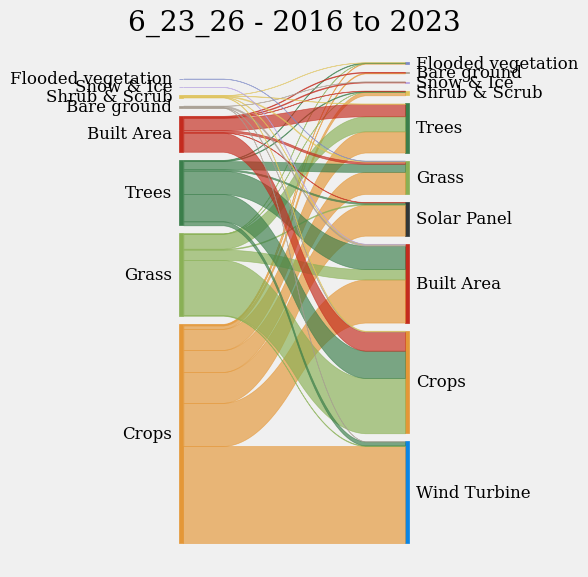

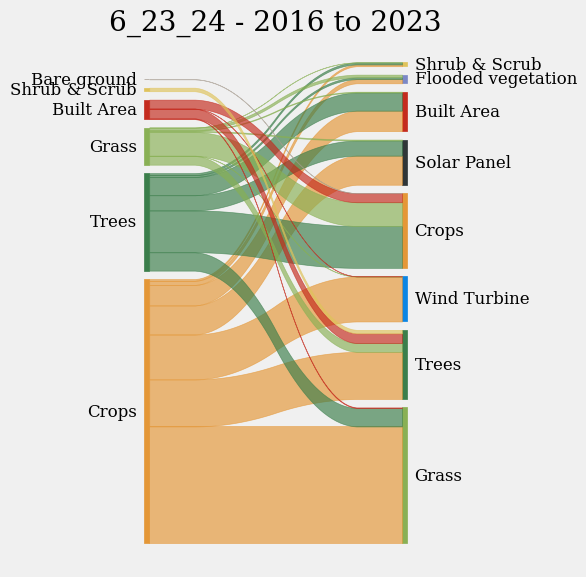

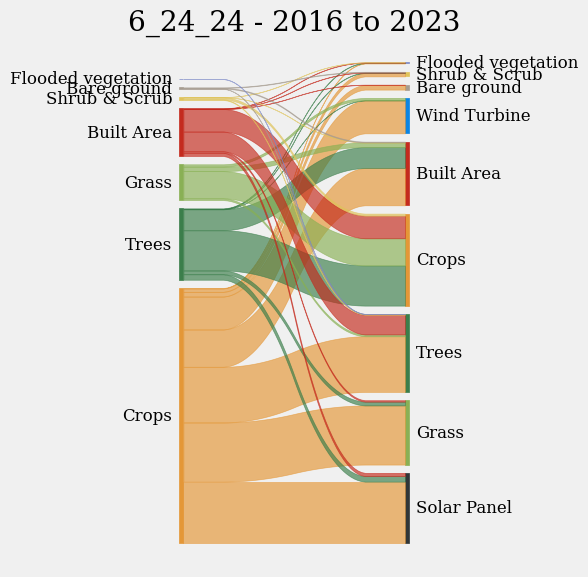

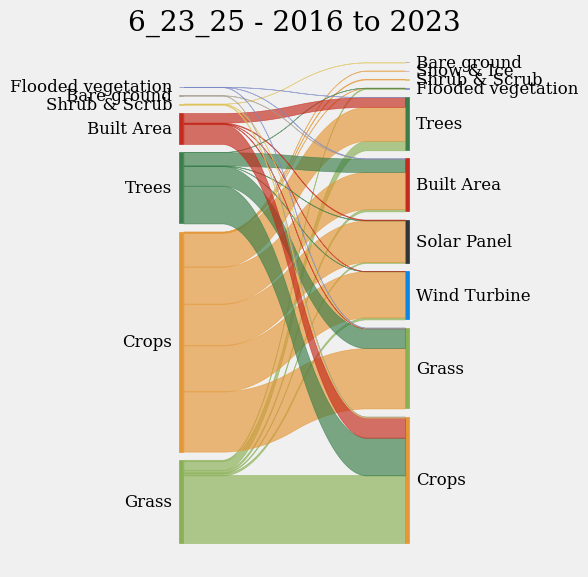

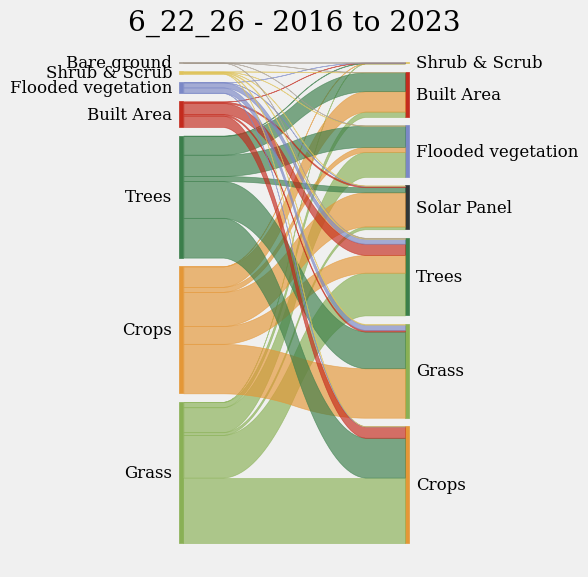

In [20]:
chipids = ["6_23_26",
"6_23_24",
"6_24_24",
"6_23_25",
"6_22_26"]

years = [str(year) for year in range(2016,2024)]
# GREEN TRANSITION
country = "Netherlands"
for chipid in chipids:
    plot_chip(chipid=chipid,
            years=years,
            country=country)

  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/41d737a37ef8be6bba33a2e4920bea48-be6e16993ae8b7c2cc8a62c4c28d032a:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_22/support_files/sentinel2_image_417.tif
100%|██████████| 436k/436k [00:00<00:00, 670kB/s]
 12%|█▎        | 1/8 [00:32<03:44, 32.03s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/4bb7e825a08d22e067de2ed3a525153c-28fdd89e364549e2f5e5716a05e2737e:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_22/support_files/sentinel2_image_428.tif
100%|██████████| 443k/443k [00:00<00:00, 652kB/s]
 25%|██▌       | 2/8 [01:06<03:19, 33.29s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/04a1b20b67ad147cf2b0a91058da5af0-d130e6f60b1a3cd148e37fbafa0f6042:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_22/support_files/sentinel2_image_676.tif
100%|██████████| 444k/444k [00:00<00:00, 668kB/s]
 38%|███▊      | 3/8 [01:42<02:53, 34.71s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/a523897331c431bdceb34ed9690bd419-ad959bbe31c7028f76413e0915d8bace:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_22/support_files/sentinel2_image_69.tif
100%|██████████| 487k/487k [00:00<00:00, 732kB/s]
 50%|█████     | 4/8 [02:17<02:18, 34.60s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/0507e8a042819337c07807c2f0b78d0f-47aefad94072c9f363a1f514b00cfadc:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_22/support_files/sentinel2_image_253.tif
100%|██████████| 438k/438k [00:00<00:00, 516kB/s]
 62%|██████▎   | 5/8 [02:53<01:46, 35.45s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/723499773db6b809ff9ff80c28b3bb50-6a228a05354f3ea9e4ac0eab11db8585:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_22/support_files/sentinel2_image_990.tif
100%|██████████| 439k/439k [00:00<00:00, 759kB/s]
 75%|███████▌  | 6/8 [03:24<01:07, 33.65s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/e2c1bdd1930e0b19ec09c6e9e485d452-7a2bcedc92939b0fed9096cafc6b8e45:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_22/support_files/sentinel2_image_128.tif
100%|██████████| 439k/439k [00:00<00:00, 658kB/s]
 88%|████████▊ | 7/8 [03:59<00:34, 34.32s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/d8334fce922809d6b1f5737c61e2ce53-8019b3771259dc05919d0696c38f556f:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_22/support_files/sentinel2_image_784.tif
100%|██████████| 429k/429k [00:00<00:00, 662kB/s]
100%|██████████| 8/8 [04:30<00:00, 33.84s/it]


Saving plot to ../plots/chips/1_3_22/1_3_22_sankey.png


  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/9209d8ca1a5e5c386b3af2b9747ea17b-a338bcd3d630f8b146d4bdf94bb6795a:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_23/support_files/sentinel2_image_285.tif
100%|██████████| 438k/438k [00:00<00:00, 660kB/s]
 12%|█▎        | 1/8 [00:31<03:38, 31.16s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/4daa3351452c7a3aaa5201fbe28958aa-aa1e4a0a5bed67dbbca0a3474c0e1718:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_23/support_files/sentinel2_image_822.tif
100%|██████████| 443k/443k [00:00<00:00, 671kB/s]
 25%|██▌       | 2/8 [01:05<03:17, 32.90s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/25725aaf8dddcc10e875553854f42c63-20f7b0a8335022d94156b1e000c6b235:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_23/support_files/sentinel2_image_875.tif
100%|██████████| 444k/444k [00:00<00:00, 633kB/s]
 38%|███▊      | 3/8 [01:39<02:47, 33.41s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/9311562a4c24a8a3bd53ea5cc714cce9-bd12902ce2a04c26a0879508ccb3d8a9:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_23/support_files/sentinel2_image_377.tif
100%|██████████| 443k/443k [00:00<00:00, 633kB/s]
 50%|█████     | 4/8 [02:08<02:06, 31.58s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/c779a0d72b815899cb6fe4e1a5959b19-c8b6fdf1d254c704bcde9486b2f2848d:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_23/support_files/sentinel2_image_341.tif
100%|██████████| 440k/440k [00:00<00:00, 532kB/s]
 62%|██████▎   | 5/8 [02:40<01:35, 31.84s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/6faf72eee7916fd3202d114d526eefba-397faae5b26804b8c69fa7bc92a80d9e:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_23/support_files/sentinel2_image_567.tif
100%|██████████| 440k/440k [00:00<00:00, 670kB/s]
 75%|███████▌  | 6/8 [03:09<01:02, 31.03s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/0577b4926433c1385bf15ef58d609e3f-bbb92e291582743d299a044b4b696a77:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_23/support_files/sentinel2_image_502.tif
100%|██████████| 437k/437k [00:00<00:00, 697kB/s]
 88%|████████▊ | 7/8 [03:39<00:30, 30.64s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/5b7dd8655ad44efdc025c57863be421b-bc638a0b61ea59e56f0404b8018b26f2:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_23/support_files/sentinel2_image_56.tif
100%|██████████| 430k/430k [00:00<00:00, 689kB/s]
100%|██████████| 8/8 [04:11<00:00, 31.40s/it]


Saving plot to ../plots/chips/1_3_23/1_3_23_sankey.png


  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/b9c74b9b9f63d081cb0a08326016c3b2-2302df9b887431caa1c7cff3ba16870c:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_21/support_files/sentinel2_image_119.tif
100%|██████████| 445k/445k [00:00<00:00, 680kB/s]
 12%|█▎        | 1/8 [00:31<03:41, 31.71s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/0a7bd2f2e1542f5457e0ff4d980cc59b-020bbd348a0204cfafa61796039ef6d9:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_21/support_files/sentinel2_image_960.tif
100%|██████████| 452k/452k [00:00<00:00, 643kB/s]
 25%|██▌       | 2/8 [01:00<03:01, 30.21s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/ac4e6b11c2c30fb14dc9fdbc4fef642f-bedd27b216437d8b96f4800fd0209b21:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_21/support_files/sentinel2_image_931.tif
100%|██████████| 454k/454k [00:00<00:00, 858kB/s]
 38%|███▊      | 3/8 [01:31<02:30, 30.18s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/56fb7df87059b5c266abc4de7c29c141-761ad3233430123666554bec847f934f:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_21/support_files/sentinel2_image_869.tif
100%|██████████| 492k/492k [00:00<00:00, 821kB/s]
 50%|█████     | 4/8 [02:01<02:00, 30.15s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/d358eca7471127467337310f21ebc448-59906606930112768ad33afd09f3d9c1:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_21/support_files/sentinel2_image_908.tif
100%|██████████| 446k/446k [00:00<00:00, 720kB/s]
 62%|██████▎   | 5/8 [02:32<01:32, 30.71s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/297c77bd0c4ce78717e8eadddf1add56-7bac63d401796157af6a7af7c2a8fb12:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_21/support_files/sentinel2_image_587.tif
100%|██████████| 448k/448k [00:00<00:00, 659kB/s]
 75%|███████▌  | 6/8 [03:04<01:02, 31.10s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/68ce76f3c82e6236dba05a5ad9270133-dff158bd33f619ba9af916abd5e6d106:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_21/support_files/sentinel2_image_871.tif
100%|██████████| 451k/451k [00:00<00:00, 716kB/s]
 88%|████████▊ | 7/8 [03:34<00:30, 30.57s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/b1f559f260bd967adeb6b1a78eb565b1-0a52e4d5e5ee902a6c07ec109ce0f15e:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_21/support_files/sentinel2_image_330.tif
100%|██████████| 440k/440k [00:00<00:00, 659kB/s]
100%|██████████| 8/8 [04:03<00:00, 30.49s/it]


Saving plot to ../plots/chips/1_3_21/1_3_21_sankey.png


  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/3167c67b2d52e0214e281ee001b60780-d8ef2d71ca2fe748ca3593555d0dcb42:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_2_18/support_files/sentinel2_image_148.tif
100%|██████████| 443k/443k [00:00<00:00, 680kB/s]
 12%|█▎        | 1/8 [00:28<03:16, 28.00s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/8e7b15cb5a6d3f15946e8a5b163ab4f2-541928e659a50b42531d9552619ad0b4:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_2_18/support_files/sentinel2_image_108.tif
100%|██████████| 447k/447k [00:00<00:00, 767kB/s]
 25%|██▌       | 2/8 [01:00<03:02, 30.38s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/6c76b12d7d72b320168f011d3166facb-70902cfb6760ba76308218eb019a4690:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_2_18/support_files/sentinel2_image_410.tif
100%|██████████| 447k/447k [00:00<00:00, 677kB/s]
 38%|███▊      | 3/8 [01:28<02:27, 29.57s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/a0fbc84481d451a4234a3f9e8d4004fb-8323fe098311fa82de3eab0323bc77e2:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_2_18/support_files/sentinel2_image_683.tif
100%|██████████| 451k/451k [00:00<00:00, 640kB/s]
 50%|█████     | 4/8 [01:55<01:53, 28.47s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/238366962defa782d2e9390a9ed6952f-789293c4bf6c4c7865eb2de42df7dae5:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_2_18/support_files/sentinel2_image_131.tif
100%|██████████| 449k/449k [00:00<00:00, 768kB/s]
 62%|██████▎   | 5/8 [02:23<01:25, 28.46s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/5a90722b870ea81fb2059f0e20fcd322-92756602b548e2f3c989e4a6869110c4:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_2_18/support_files/sentinel2_image_596.tif
100%|██████████| 438k/438k [00:00<00:00, 688kB/s]
 75%|███████▌  | 6/8 [02:54<00:58, 29.06s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/bf53b29f3db4dc6b760ad5cb051222a3-a46a89dce771c6a5e36ffada19088415:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_2_18/support_files/sentinel2_image_749.tif
100%|██████████| 451k/451k [00:00<00:00, 637kB/s]
 88%|████████▊ | 7/8 [03:24<00:29, 29.39s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/c5d17b78de2ac22eb12e0f8a84d485bb-e565e7f348733d4c55299b6caafee510:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_2_18/support_files/sentinel2_image_710.tif
100%|██████████| 451k/451k [00:00<00:00, 707kB/s]
100%|██████████| 8/8 [03:51<00:00, 28.99s/it]


Saving plot to ../plots/chips/1_2_18/1_2_18_sankey.png


  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/5bd758000ce9c6a8a92634c04a5ba68a-91d651271bb19e1ef84e34f4dd36f217:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_16/support_files/sentinel2_image_961.tif
100%|██████████| 454k/454k [00:00<00:00, 775kB/s]
 12%|█▎        | 1/8 [00:27<03:14, 27.83s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/38a1865ed7feb616423efc0707c9d9c8-1c62bf4d5106b76b2f3518d4a00358eb:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_16/support_files/sentinel2_image_916.tif
100%|██████████| 454k/454k [00:00<00:00, 670kB/s]
 25%|██▌       | 2/8 [00:55<02:46, 27.79s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/cf3438e6b4fa18bb81873d8992df188a-52c4571c2fb4c86ab09de2bdd02cd4ed:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_16/support_files/sentinel2_image_82.tif
100%|██████████| 457k/457k [00:00<00:00, 645kB/s]
 38%|███▊      | 3/8 [01:24<02:20, 28.12s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/8a753b004b730fdc264eb8bbdf010331-a6c0bf77a31899bba1aca5841aaf692e:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_16/support_files/sentinel2_image_300.tif
100%|██████████| 457k/457k [00:00<00:00, 762kB/s]
 50%|█████     | 4/8 [01:52<01:53, 28.43s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/8e53486a139f0512f24f0592c943ad70-c80c33d21d22595af23ced8412308cdc:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_16/support_files/sentinel2_image_25.tif
100%|██████████| 453k/453k [00:00<00:00, 694kB/s]
 62%|██████▎   | 5/8 [02:20<01:23, 27.97s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/e181c0bddd4b259ba1aa218aad27cebc-34cccbff6a51777b84d5c5223eedd7bd:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_16/support_files/sentinel2_image_604.tif
100%|██████████| 449k/449k [00:00<00:00, 675kB/s]
 75%|███████▌  | 6/8 [02:56<01:01, 30.74s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/f74dd507496f767320fa01e3b2dbcbac-61e33f45a0a319790cf83807a478c9a9:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_16/support_files/sentinel2_image_398.tif
100%|██████████| 457k/457k [00:00<00:00, 673kB/s]
 88%|████████▊ | 7/8 [03:24<00:30, 30.04s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/f48652ba50e9d18820e11a8a737df691-961af5ebcf05c5aeb2c549fd84011523:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_3_16/support_files/sentinel2_image_725.tif
100%|██████████| 464k/464k [00:00<00:00, 740kB/s]
100%|██████████| 8/8 [03:52<00:00, 29.12s/it]


Saving plot to ../plots/chips/1_3_16/1_3_16_sankey.png


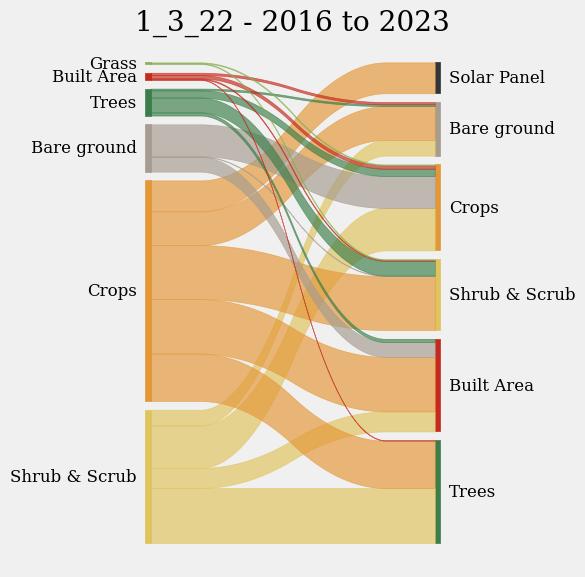

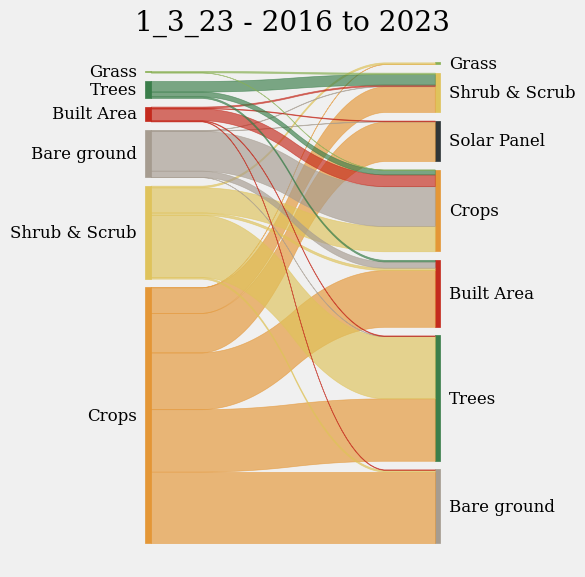

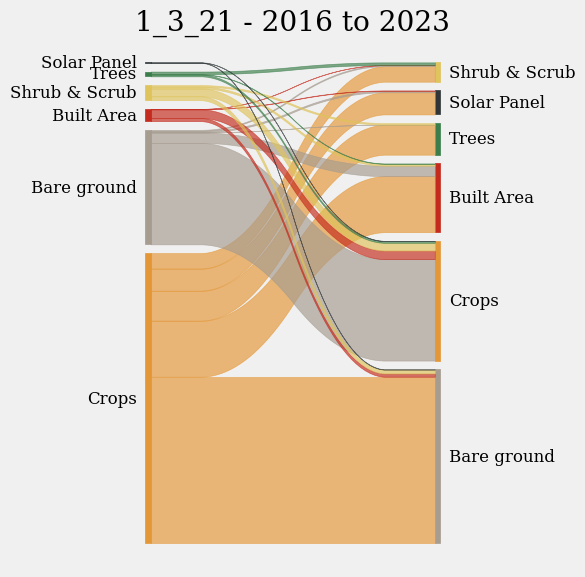

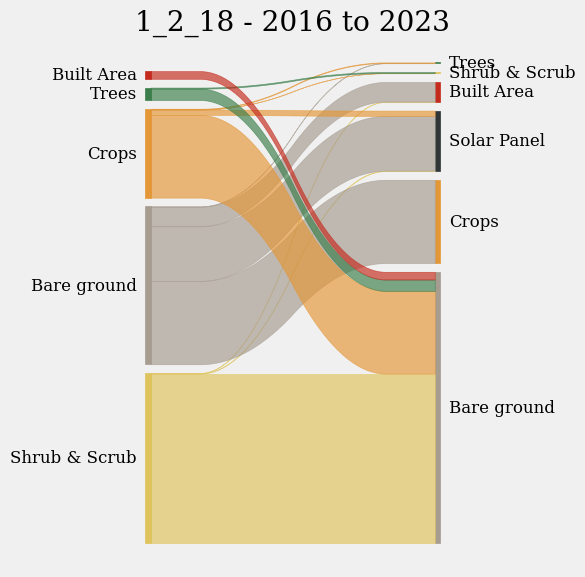

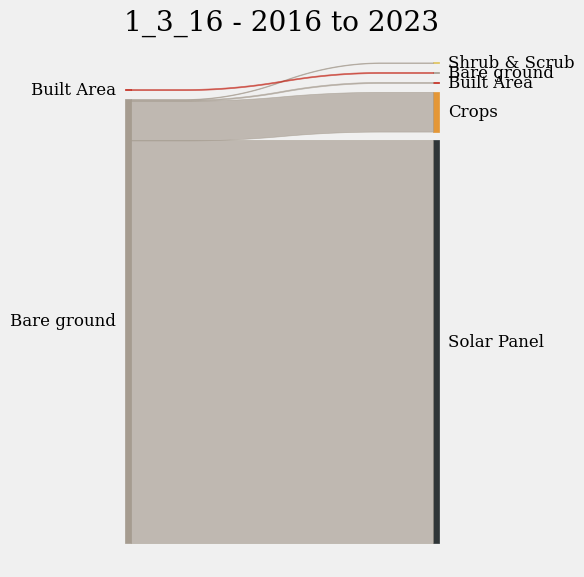

In [21]:
chipids = ["1_3_22",
"1_3_23",
"1_3_21",
"1_2_18","1_3_16"]

years = [str(year) for year in range(2016,2024)]
# GREEN TRANSITION
country = "Israel"
for chipid in chipids:
    plot_chip(chipid=chipid,
            years=years,
            country=country)

  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/cf1a4935861cba2072a19f00a177b2cb-d4975b3773a5a1a6ab0b458fc7119b7d:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_2_19/support_files/sentinel2_image_653.tif
100%|██████████| 451k/451k [00:00<00:00, 660kB/s]
 12%|█▎        | 1/8 [00:59<06:54, 59.20s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/e04c65fc28f0d94b4809f3d3e78fbe96-ce6ed2d78f53b7ee6864c31295f24c69:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_2_19/support_files/sentinel2_image_33.tif
100%|██████████| 458k/458k [00:00<00:00, 713kB/s]
 25%|██▌       | 2/8 [01:57<05:50, 58.45s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/cc1c4f17f4e9a96f05f4283087cf8b7c-a57a33fda264f756936f6004ec64b13b:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_2_19/support_files/sentinel2_image_809.tif
100%|██████████| 457k/457k [00:00<00:00, 761kB/s]
 38%|███▊      | 3/8 [02:48<04:37, 55.42s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/2d5d4983f945f414a937afde57cbda24-deff10d98af908899941b6b714243a21:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_2_19/support_files/sentinel2_image_938.tif
100%|██████████| 471k/471k [00:00<00:00, 741kB/s]
 50%|█████     | 4/8 [03:48<03:48, 57.24s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/9b1b0cfb1331eb3c2b0cce99cd323be8-7584caebd6b551da7bd73bcbfbec3285:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_2_19/support_files/sentinel2_image_18.tif
100%|██████████| 459k/459k [00:00<00:00, 693kB/s]
 62%|██████▎   | 5/8 [04:46<02:52, 57.39s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/64814de74613be420745852901755307-f0b8d0246e7ae59f7b6944039abb989f:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_2_19/support_files/sentinel2_image_286.tif
100%|██████████| 453k/453k [00:00<00:00, 641kB/s]
 75%|███████▌  | 6/8 [05:38<01:51, 55.64s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/d0fc0f0e775c1d564b4c6000db85feef-8e917f9cf037ad2edffab386ac5a8058:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_2_19/support_files/sentinel2_image_52.tif
100%|██████████| 460k/460k [00:00<00:00, 753kB/s]
 88%|████████▊ | 7/8 [06:36<00:56, 56.16s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/44ceaa2fa65ab532272f161c8600fa1b-1b2ed5cb33960d0d8405bb0103997f20:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/1_2_19/support_files/sentinel2_image_122.tif
100%|██████████| 451k/451k [00:00<00:00, 644kB/s]
100%|██████████| 8/8 [07:31<00:00, 56.40s/it]


Saving plot to ../plots/chips/1_2_19/1_2_19_sankey.png


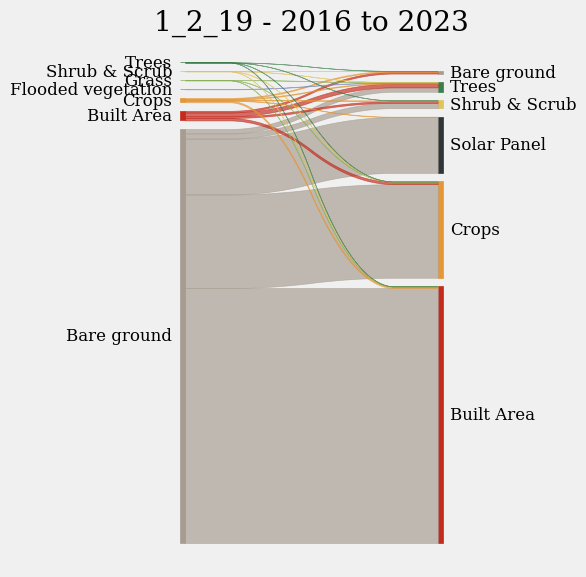

In [8]:
# AGRICULTURAL EXPANSION 

chipid = "1_2_19"


years = [str(year) for year in range(2016,2024)]
# GREEN TRANSITION
country = "Israel"
plot_chip(chipid=chipid,
        years=years,
        country=country)

In [7]:
import pandas as pd
outliers = pd.read_csv('../data/change_queries/outliers.csv')


,country,cluster
0,Denmark,2
9,Denmark,0
10,Israel,1
11,Israel,2
13,Netherlands,2
24,Netherlands,0
27,Estonia,1
39,Estonia,3
51,Estonia,0


Country : Denmark - Chipid : 12_1_4 - outlier in cluster 2, corresponding to Estonia
Country : Denmark - Chipid : 13_4_7 - outlier in cluster 0, corresponding to Israel
Country : Israel - Chipid : 1_8_35 - outlier in cluster 1, corresponding to Netherlands
Country : Israel - Chipid : 1_12_40 - outlier in cluster 2, corresponding to Estonia
Country : Netherlands - Chipid : 6_13_11 - outlier in cluster 2, corresponding to Estonia


Country : Denmark - Chipid : 13_4_7 - outlier in cluster 0, corresponding to Israel


  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/93983a1ac86f1f2cd82e404822af0c6e-f091f1912ef82bb47e4be8b5e85d9f7b:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/13_4_7/support_files/sentinel2_image_605.tif
100%|██████████| 519k/519k [00:00<00:00, 718kB/s]
 12%|█▎        | 1/8 [00:39<04:38, 39.82s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/d4f901fdc3628500fdbffff3c6be5e89-a56ee16047dff64cb50d8494527bd3c0:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/13_4_7/support_files/sentinel2_image_276.tif
100%|██████████| 501k/501k [00:00<00:00, 701kB/s]
 25%|██▌       | 2/8 [01:28<04:31, 45.19s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/36c948f2840787520e8caef807c0a1b3-c3e858ae2039bab6ebf9de6054ae98fd:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/13_4_7/support_files/sentinel2_image_851.tif
100%|██████████| 521k/521k [00:00<00:00, 795kB/s]
 38%|███▊      | 3/8 [02:04<03:24, 40.93s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/94a2c6b3f72c0560ec84218081ee911a-fdf026e2b7f9e4939835d977b925be9d:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/13_4_7/support_files/sentinel2_image_576.tif
100%|██████████| 517k/517k [00:00<00:00, 779kB/s]
 50%|█████     | 4/8 [02:40<02:35, 38.89s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/aa6bb9e9f13d1f9e2179bbc255517f01-697bf5a488c011170a90a3c66399ed14:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/13_4_7/support_files/sentinel2_image_15.tif
100%|██████████| 547k/547k [00:00<00:00, 763kB/s]
 62%|██████▎   | 5/8 [03:15<01:52, 37.54s/it]

Getting LULC data
Getting satellite image
../plots/chips/13_4_7/support_files/sentinel2_image_752.tif already exists. Skip downloading. Set overwrite=True to overwrite.


 75%|███████▌  | 6/8 [03:47<01:11, 35.53s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/d8acce04552f05bb463100fc22c9205a-13b8c11b8957ee5f5d9489c4731f4760:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/13_4_7/support_files/sentinel2_image_283.tif
100%|██████████| 507k/507k [00:00<00:00, 775kB/s]
 88%|████████▊ | 7/8 [04:24<00:35, 35.96s/it]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/95d4456c983aea52a7e95f0fbb980fd6-6ea4a8801c9373aaba431e325d44e918:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/13_4_7/support_files/sentinel2_image_422.tif
100%|██████████| 585k/585k [00:00<00:00, 814kB/s]
100%|██████████| 8/8 [04:58<00:00, 37.32s/it]


Saving plot to ../plots/chips/13_4_7/13_4_7_sankey.png
Country : Netherlands - Chipid : 6_10_22 - outlier in cluster 0, corresponding to Israel


  0%|          | 0/8 [00:00<?, ?it/s]

Getting LULC data
Getting satellite image


Downloading...
From: https://earthengine.googleapis.com/v1/projects/masterthesis-aske/thumbnails/5a50fa73f6b47999ef4244869c8597be-15c5215d19a42fa5a841481f12bce9ac:getPixels
To: /Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/plots/chips/6_10_22/support_files/sentinel2_image_424.tif
100%|██████████| 497k/497k [00:00<00:00, 742kB/s]
 12%|█▎        | 1/8 [01:04<07:29, 64.26s/it]

Getting LULC data
Getting satellite image


 12%|█▎        | 1/8 [03:30<24:31, 210.19s/it]


EEException: User memory limit exceeded.

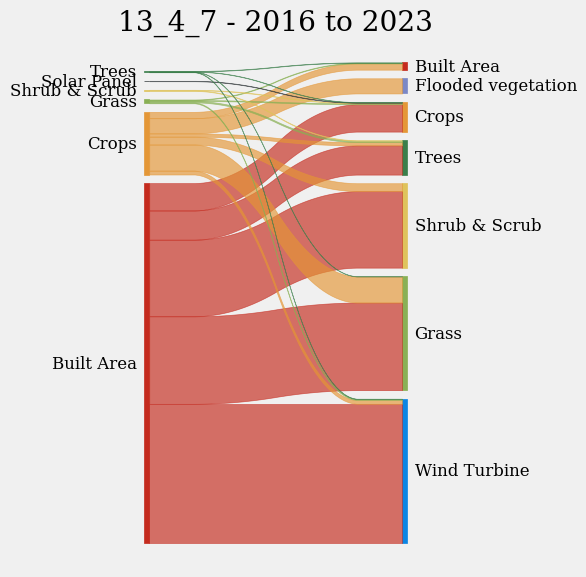

In [11]:
# OUTLIERS
outliers = pd.read_csv('../data/change_queries/outliers.csv')

cluster_country_mapping = {'0':'Israel','1':"Netherlands","2":"Estonia","3":"Denmark"}
years = [str(year) for year in range(2016,2024)]

for k,outlier_type in outliers[['country','cluster']].drop_duplicates().sort_values('cluster').iterrows():
    chosen_outlier = outliers[(outliers['country']==outlier_type['country']) & (outliers['cluster']==outlier_type['cluster'])].head(1)
    country = chosen_outlier['country'].values[0]
    chipid = chosen_outlier['chipid'].values[0]
    cluster = chosen_outlier['cluster'].values[0]
    print(f"Country : {country} - Chipid : {chipid} - outlier in cluster {cluster}, corresponding to {cluster_country_mapping[str(cluster)]}")
    
    plot_chip(chipid=chipid,
        years=years,
        country=country)